<img src="neid_thin.png" width="600"></img>

<h1><center>NEID Data Analysis Tutorial: Part 2 </center></h1>

<center><b>Author</b>: Arpita Roy (aroy@stsci.edu) | <b>Latest update</b>: June 15, 2021.</center>

--------------------------------------------------------------


# Table of contents
1. [Introduction](#intro)
2. [Open FITS File](#fits)
3. [Continuum Normalization](#fitcont)
4. [Peak Finding](#findpeak)
5. [Peak Fitting](#fitpeak)


## 1. Introduction <a class="anchor" id="intro"></a>
[NEID](https://neid.psu.edu/) is an extreme precision, high resolution [echelle](https://en.wikipedia.org/wiki/Echelle_grating) spectrograph that is designed for exoplanet discovery and characterization. This is a beginner's guide to NEID data analysis. In this tutorial, we will learn to look at continuum normalize NEID data, and do some basic peak finding to locate absorption lines. 

This kind of pre-processing is necessary for scrutinizing line behaviors, particularly for research projects related to stellar activity monitoring. 

Let's start by importing all the libraries we will need.

In [1]:
# Import file handling libraries:
import os
from glob import glob

# Import numpy and matplotlib:
import numpy as np
import matplotlib.pyplot as plt

# Import astropy for fits handling:
from astropy.io import fits

# Model fitting
from pyreduce import continuum_normalization
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from astropy.modeling import models, fitting
from astropy import modeling
from lmfit.models import SkewedGaussianModel

In [2]:
# You can set your plotting style of choice here
plt.style.use(['seaborn-darkgrid'])

## 2. Open FITS File <a class="anchor" id="fits"></a>
We have a sample observation of the Sun to look at. Let's open up the FITS file and explore its contents. Note the NEID file naming convention: neidL#_YYYYMMDDThhmmss.fits, where # is 0, 1, or 2 for the data level, and YYYYMMDDThhmmss is the timestamp corresponding to the beginning of the exposure. So this observation was taken on 8th February 2021, a little after 7pm UT.

In [3]:
hdul = fits.open('neidL2_20210208T191024.fits')

In [4]:
flux = hdul['SCIFLUX'].data
wave = hdul['SCIWAVE'].data

These are both arrays with the same dimensions. They have 122 spectral orders, each with 9216 pixels across the large NEID CCD.

## 3. Continuum Normalization <a class="anchor" id="fitcont"></a>

There are many ways to do continuum normalization, each with pros and cons. We will try a few different methods here. To begin with, let's use just one order.

In [5]:
order = 50
pix_array = np.arange(flux.shape[1])

In [6]:
# Set NaNs to zero
flux[np.isnan(flux)] = 0
wave[np.isnan(wave)] = 0

### a) Fit a Polynomial
Perhaps the simplest way to try and remove the blaze function is to use a polynomial. Let's write a function to fit the spectrum with a polynomial in chunks.

In [7]:
def chunked_continuum_fit(x, y, percentile_cut=95.0, nchunks=15, deg=5):
    chunks_x = np.zeros(nchunks) #Chunk up spectrum and store mini-spectrum chunks in lists
    chunks_y = np.zeros(nchunks)
    npixels = len(x)
    pixels_per_chunk = npixels / nchunks
    for i in range(nchunks): #Loop through each chunk
        chunk_i1 = np.int(i*pixels_per_chunk)
        chunk_i2 = np.int((i+1)*pixels_per_chunk)
        if chunk_i2 > npixels: #Chop end of last chunk
            chunk_i2 = npixels
        chunks_y[i] = np.nanpercentile(y[chunk_i1:chunk_i2], percentile_cut) #Chunk y is xxth percentile of chunk
        chunks_x[i] = 0.5*(x[chunk_i1:chunk_i2][0]+x[chunk_i1:chunk_i2][-1]) #Chunk x is just center of chunk
    smooth_y = savgol_filter(chunks_y, 11, 1) # add some smoothin to avoid "falling" into lines
    pfit = np.polyfit(chunks_x, smooth_y, deg=deg) #fit polynomial to chunks
    cs = CubicSpline(chunks_x, chunks_y)
    return np.polyval(pfit, x), cs, chunks_x, chunks_y #Return continuum array generated from polynomial fit

In [8]:
chunkfit, cs,chunks_x, chunks_y = chunked_continuum_fit(pix_array,flux[order,:],percentile_cut=90.0, nchunks=100, deg=7)


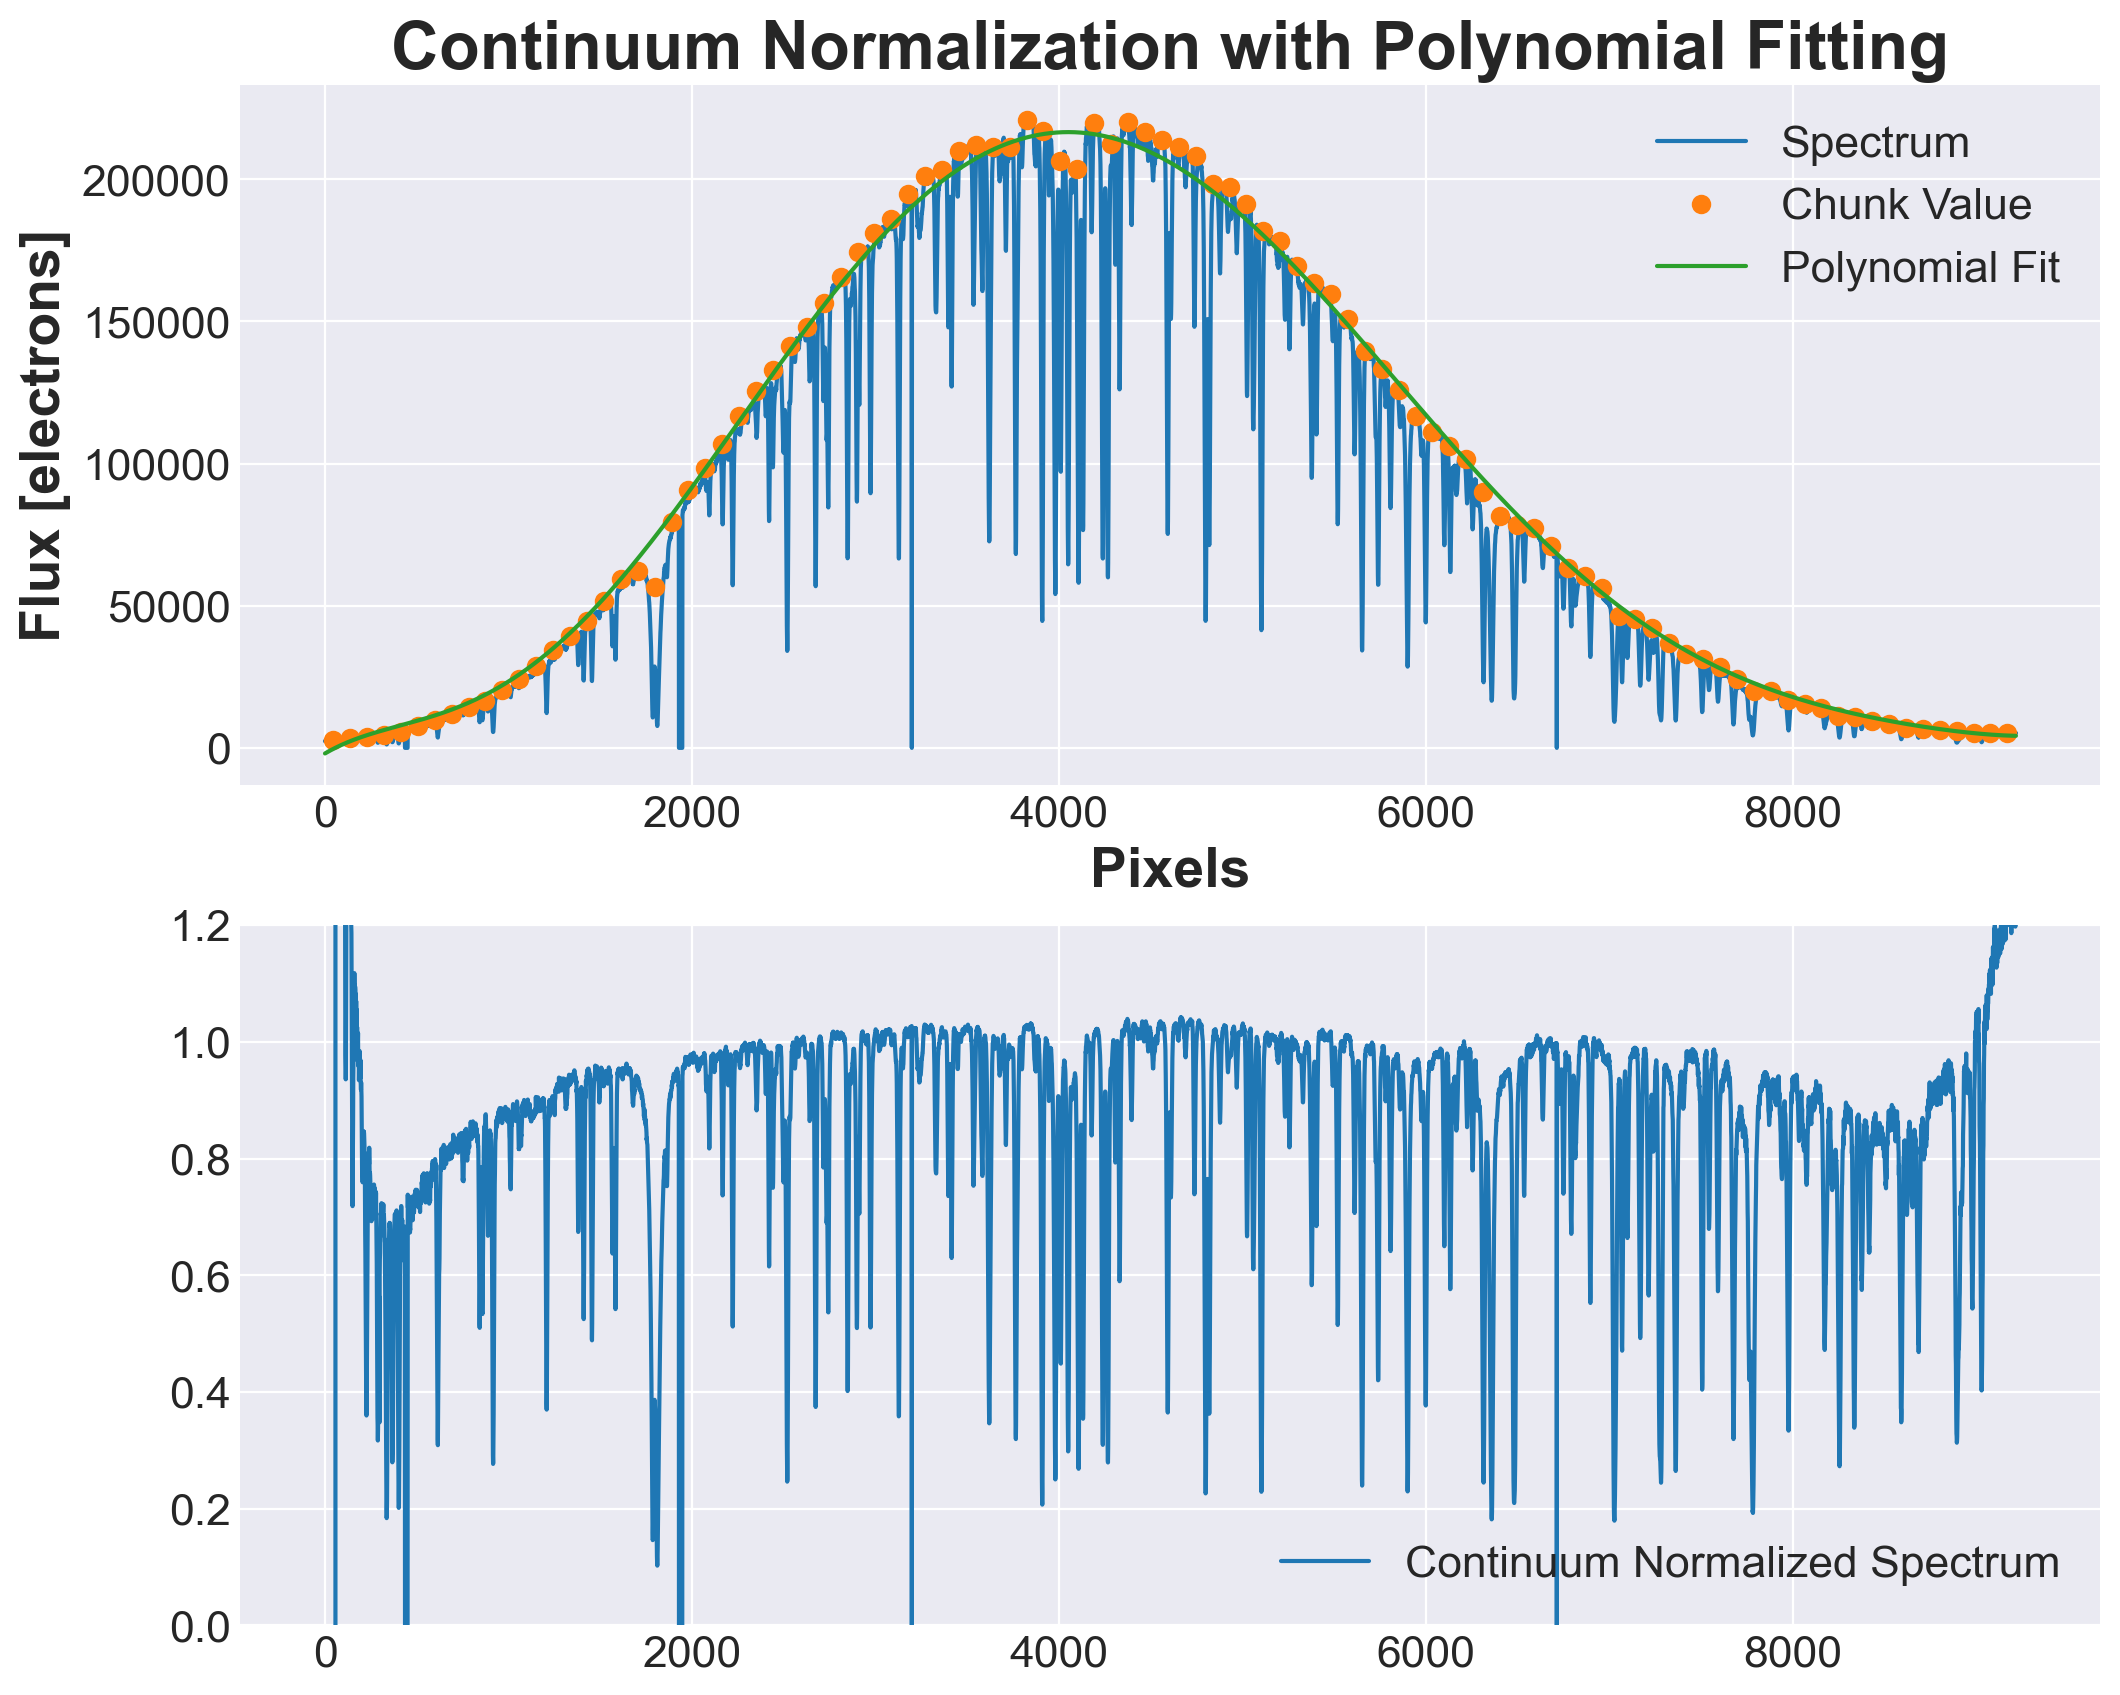

In [9]:
fig,ax = plt.subplots(nrows=2,figsize=(12,10))
ax[0].plot(flux[order,:],label='Spectrum')
ax[0].plot(chunks_x, chunks_y,'o',label='Chunk Value')
ax[0].plot(chunkfit,label='Polynomial Fit')
ax[0].set_title('Continuum Normalization with Polynomial Fitting'.format(order))
ax[0].set_xlabel('Pixels')
ax[0].set_ylabel('Flux [electrons]')
ax[0].legend()
ax[1].plot(flux[order,:]/chunkfit,label='Continuum Normalized Spectrum')
ax[1].set_ylim(0,1.2)
ax[1].legend()
plt.show()

We did decently in the middle of the order but the edges are not being fit very well. This is because we extract the NEID orders far beyond the blaze, where it is not fit represented well with a single polynomial.  

### b) Cubic Spline Fit

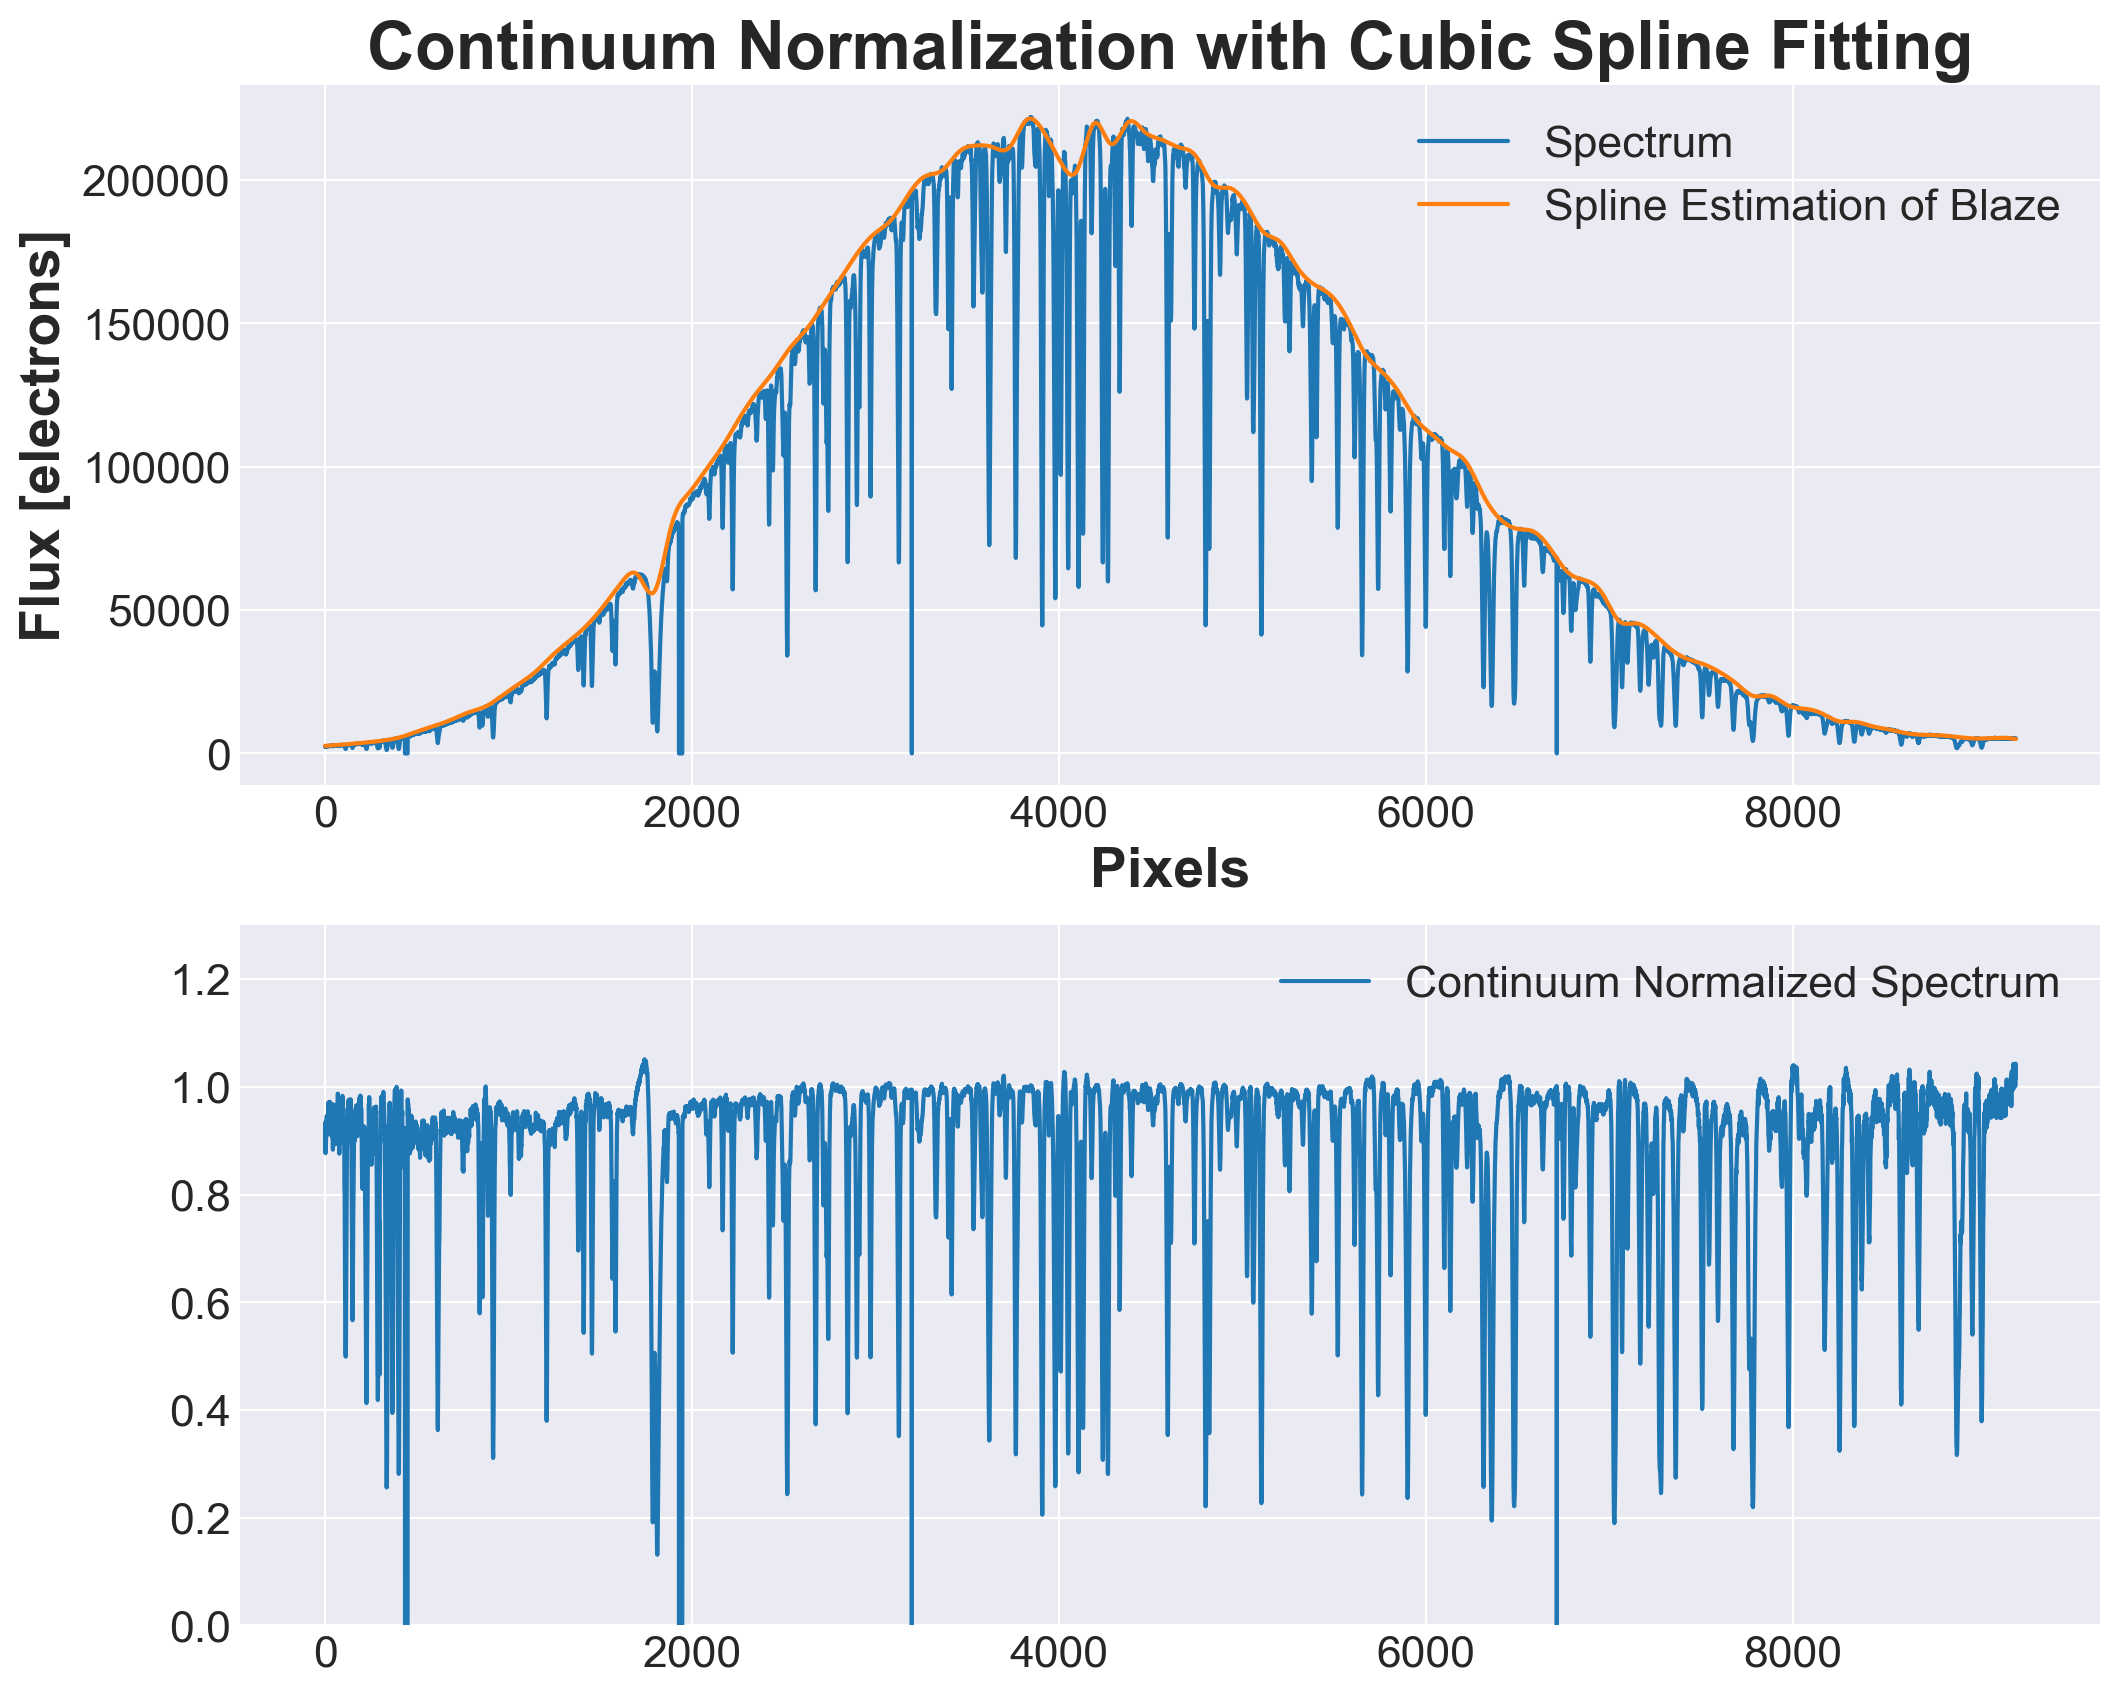

In [10]:
fig,ax = plt.subplots(nrows=2,figsize=(12,10))
ax[0].plot(flux[order,:],label='Spectrum')
ax[0].plot(cs(pix_array),label='Spline Estimation of Blaze')
ax[0].set_title('Continuum Normalization with Cubic Spline Fitting'.format(order))
ax[0].set_xlabel('Pixels')
ax[0].set_ylabel('Flux [electrons]')
ax[0].legend()
ax[1].plot(flux[order,:]/cs(pix_array),label='Continuum Normalized Spectrum')
ax[1].set_ylim(0,1.3)
ax[1].legend()
plt.show()

This looks better, but is actually not good because it fits out parts of the absorption lines. This changes their shape in a way that will affect all subsequent measurements of the lines. Splines have to be carefully controlled since they are very flexible.

### c) PyReduce
[PyReduce](https://github.com/AWehrhahn/PyReduce) is a public data reduction pipeline for echelle spectrographs. Here we will only use their continuum normalization routine. This is actually a very effective routine, but requires a good guess of the blaze function from a flat lamp spectrum. Let us say we don't have that, and try to provide an empirical guess using smoothing.

Text(0, 0.5, 'Flux [electrons]')

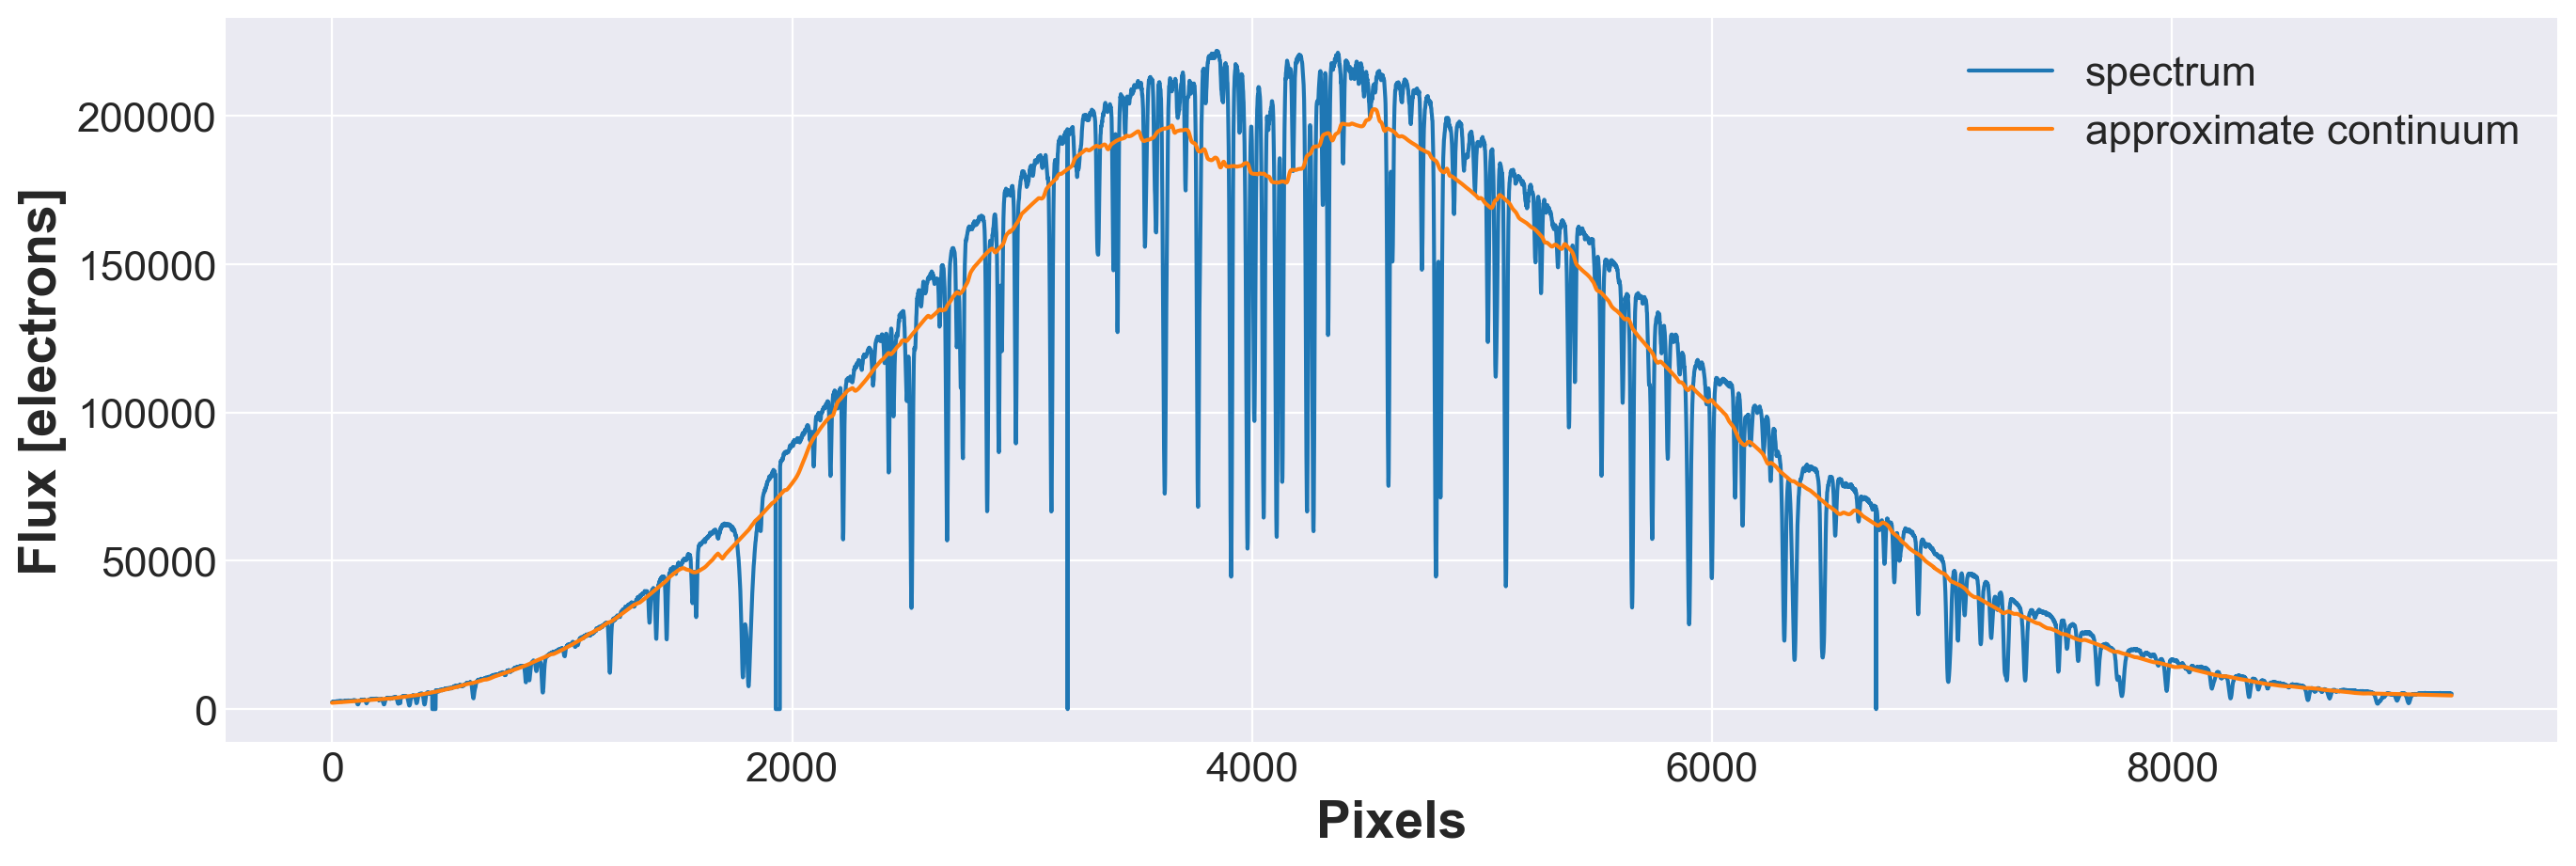

In [11]:
cont = np.ma.array(savgol_filter(flux[50:51,:], 501, 1))
plt.plot(flux[50,:],label='spectrum')
plt.plot(cont[0,:],label='approximate continuum')
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Flux [electrons]')

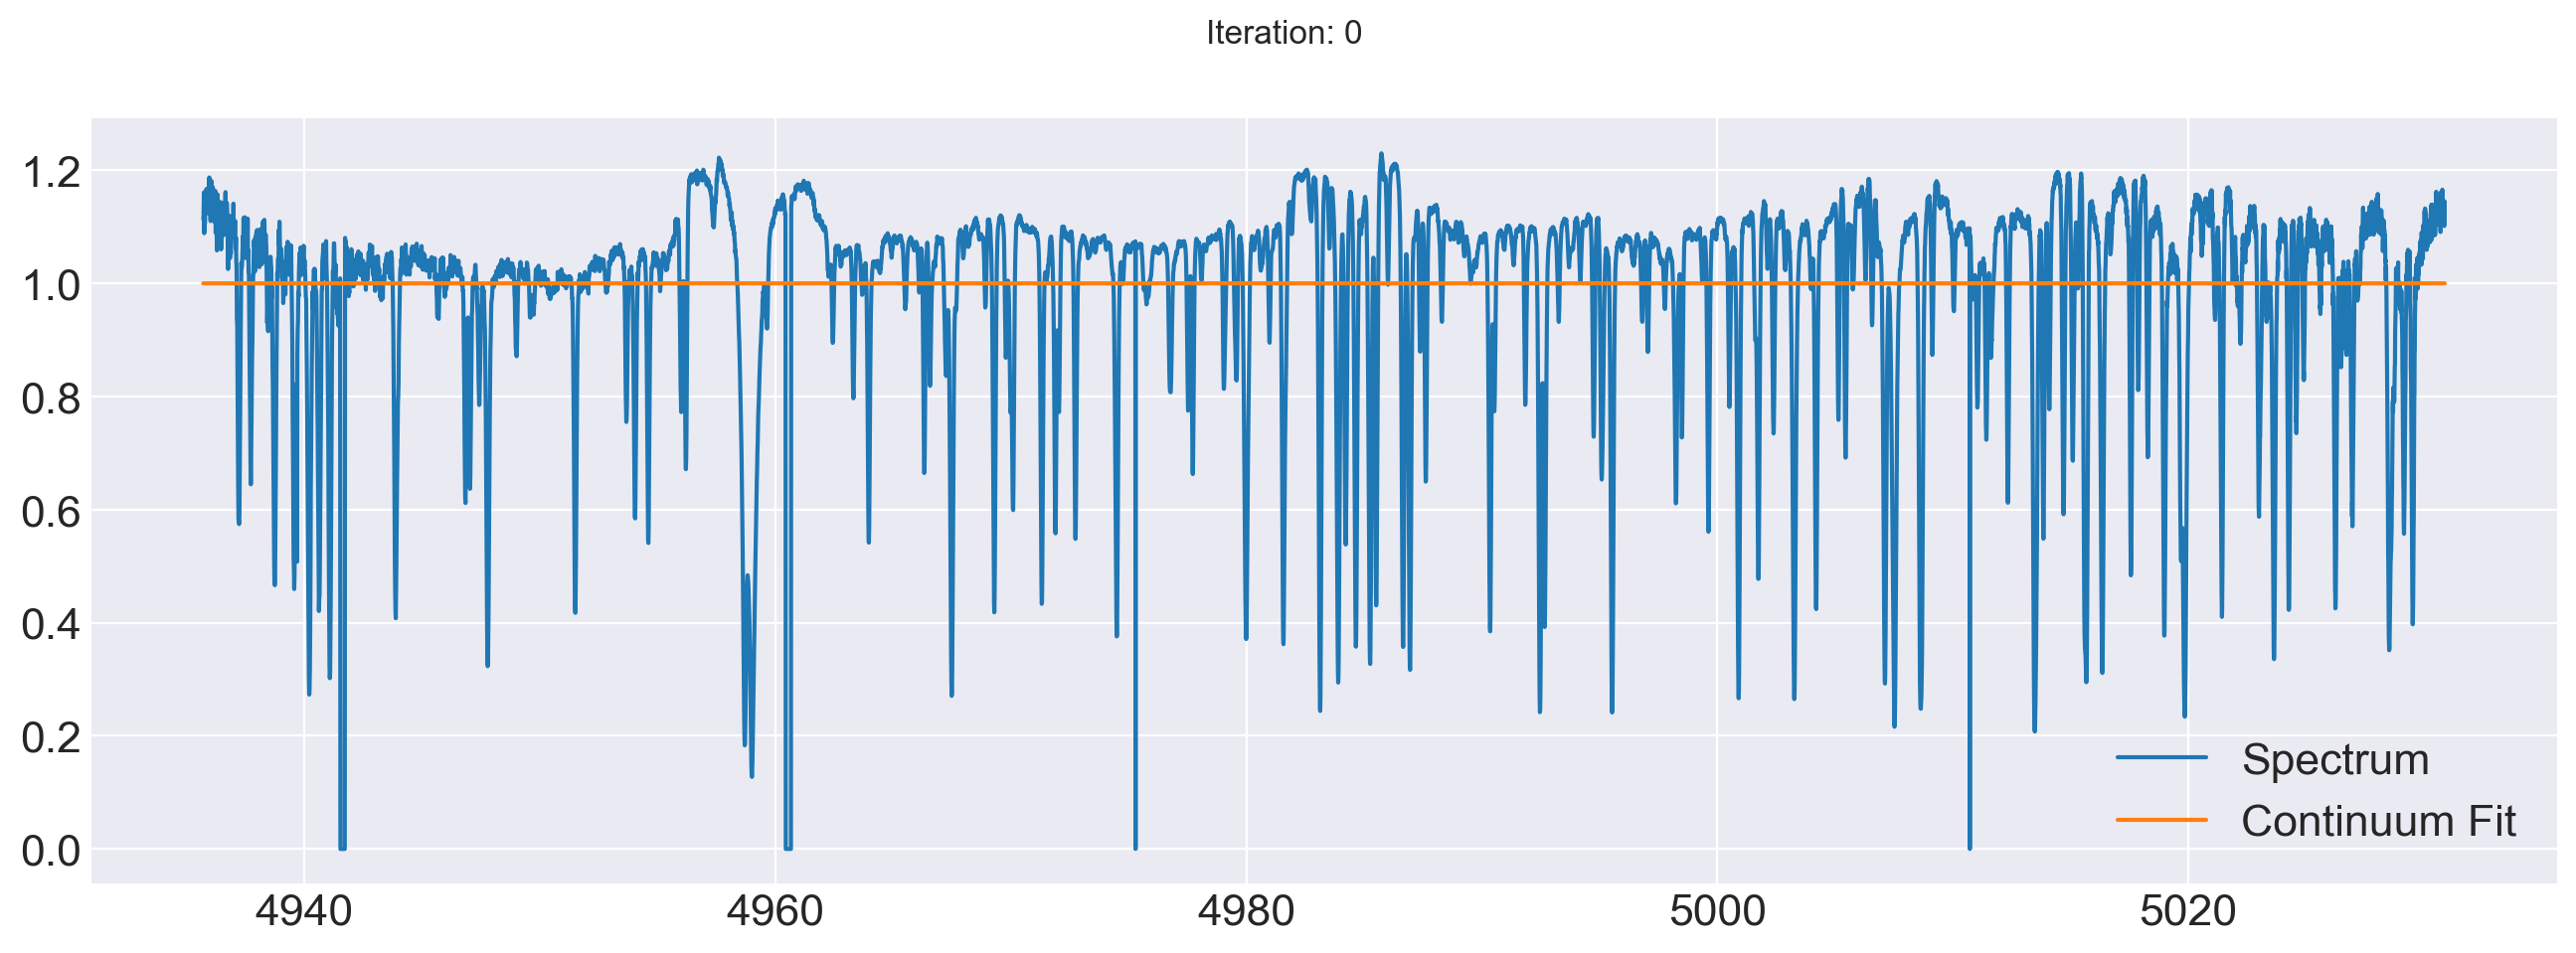

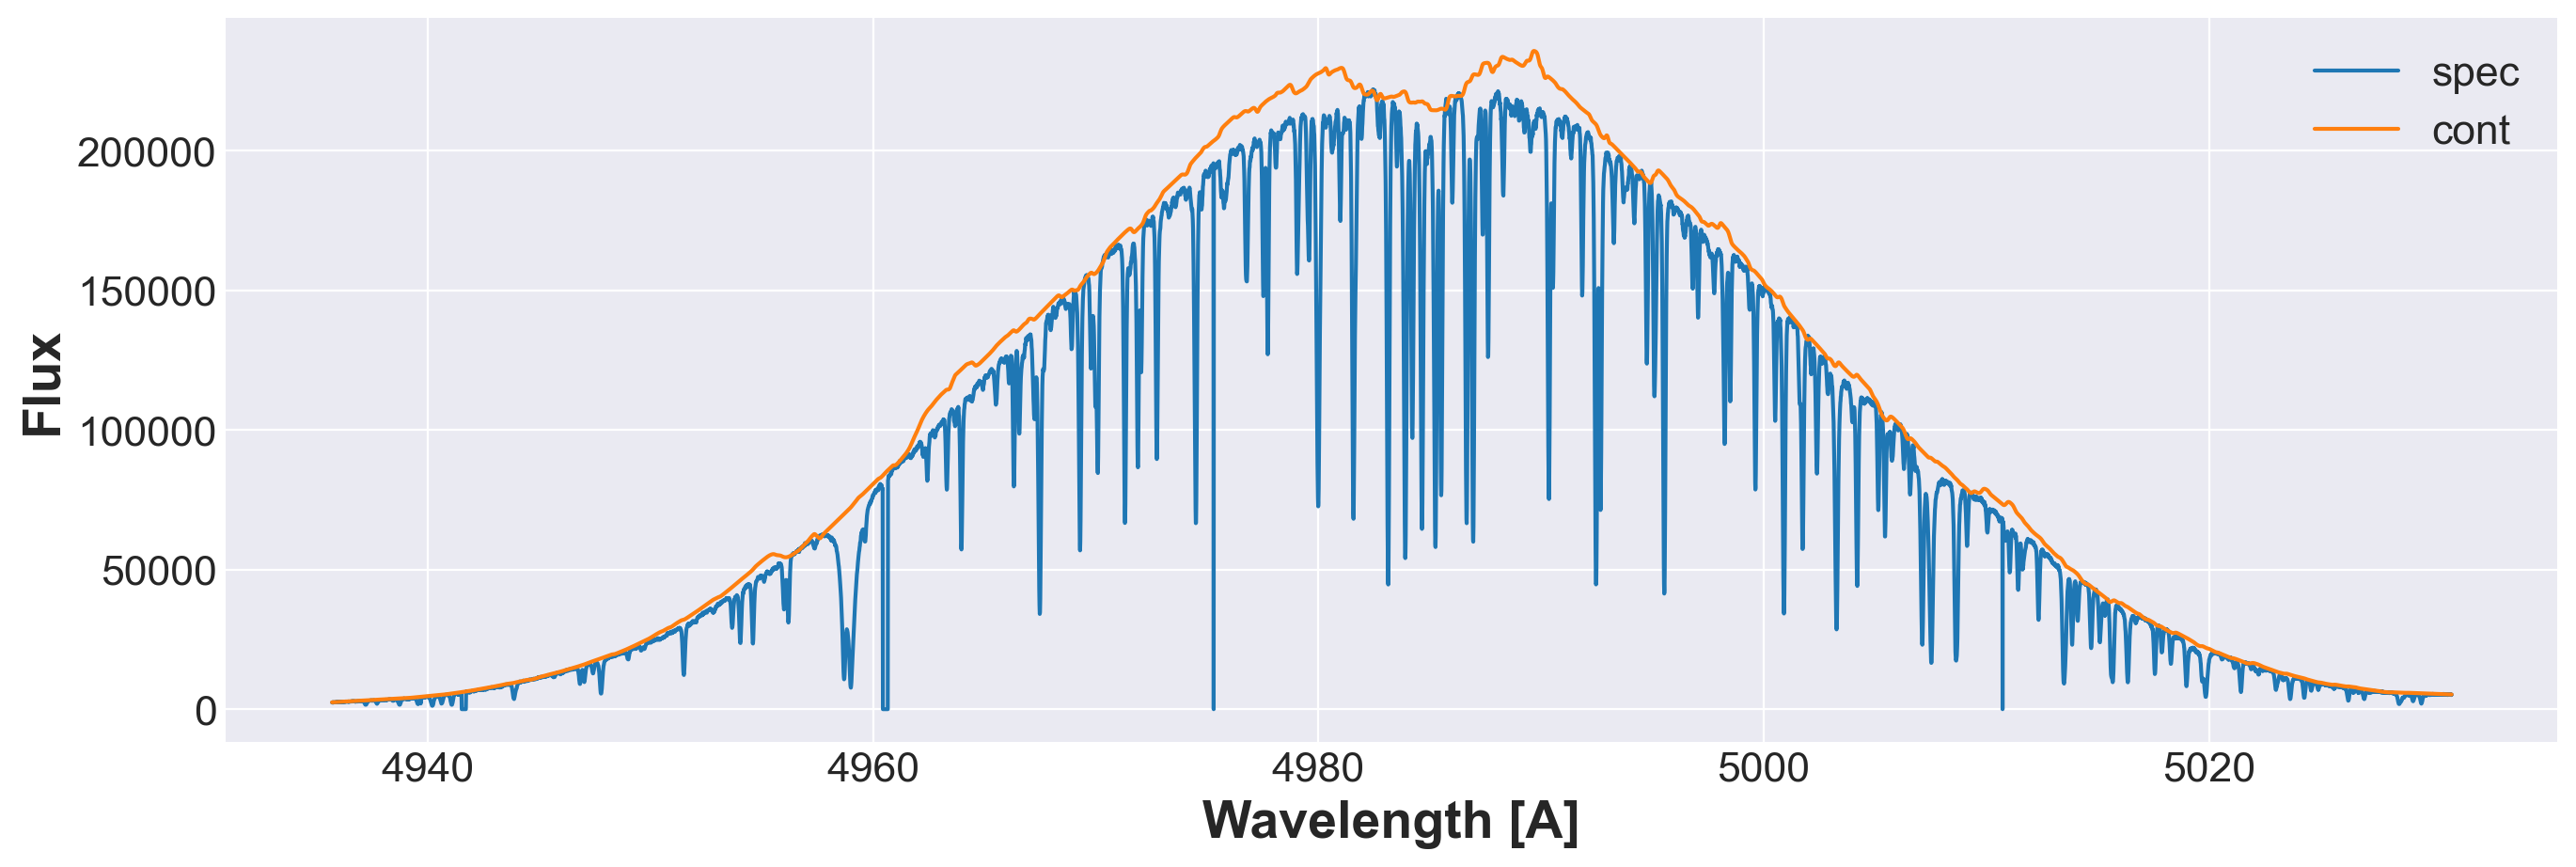

In [12]:
cont = np.ma.array(savgol_filter(flux[50:51,:], 501, 1))
sigm = np.ma.array(np.sqrt(flux[50:51,:]))
result = continuum_normalization.continuum_normalize(np.ma.array(flux[50:51,:]),np.ma.array(wave[50:51,:]),cont,sigm,plot=True)

Text(0, 0.5, 'Normalized Flux')

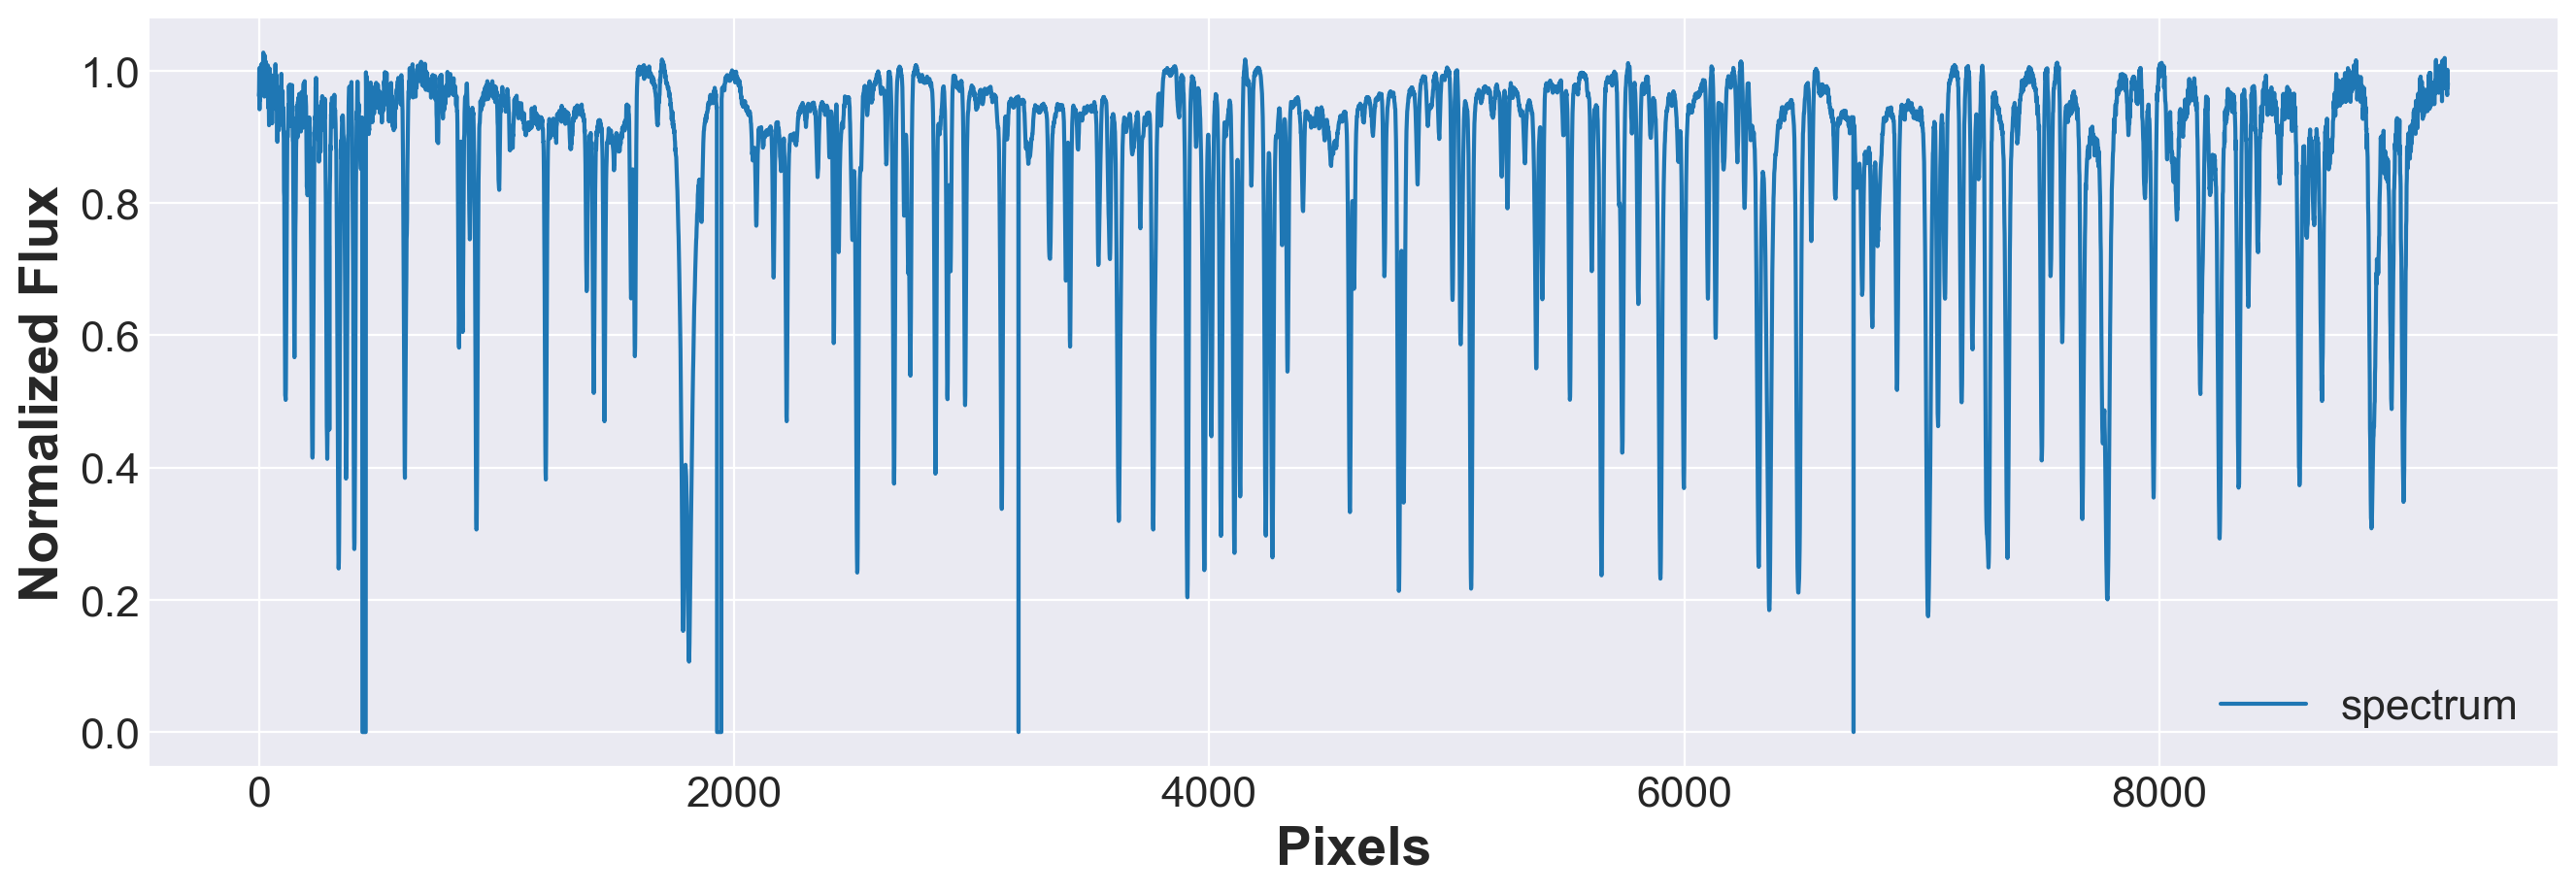

In [13]:
cont = np.ma.array(savgol_filter(flux[50:51,:], 501, 1))
plt.plot(flux[50,:]/result[0,:],label='spectrum')
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')

This didn't work very well because our guess was poor. You can see the routine did it's best by moving our guess to a best fit location.

### C) Fit Gaussian

In [14]:
# Gaussian model to use - you need to give it reasonable starting parameters
blaze_init = models.Gaussian1D(amplitude=2e5, mean=4500, stddev=1000)
fit_blaze = fitting.LevMarLSQFitter()
blaze = fit_blaze(blaze_init, chunks_x, chunks_y)

Text(0, 0.5, 'Flux [electrons]')

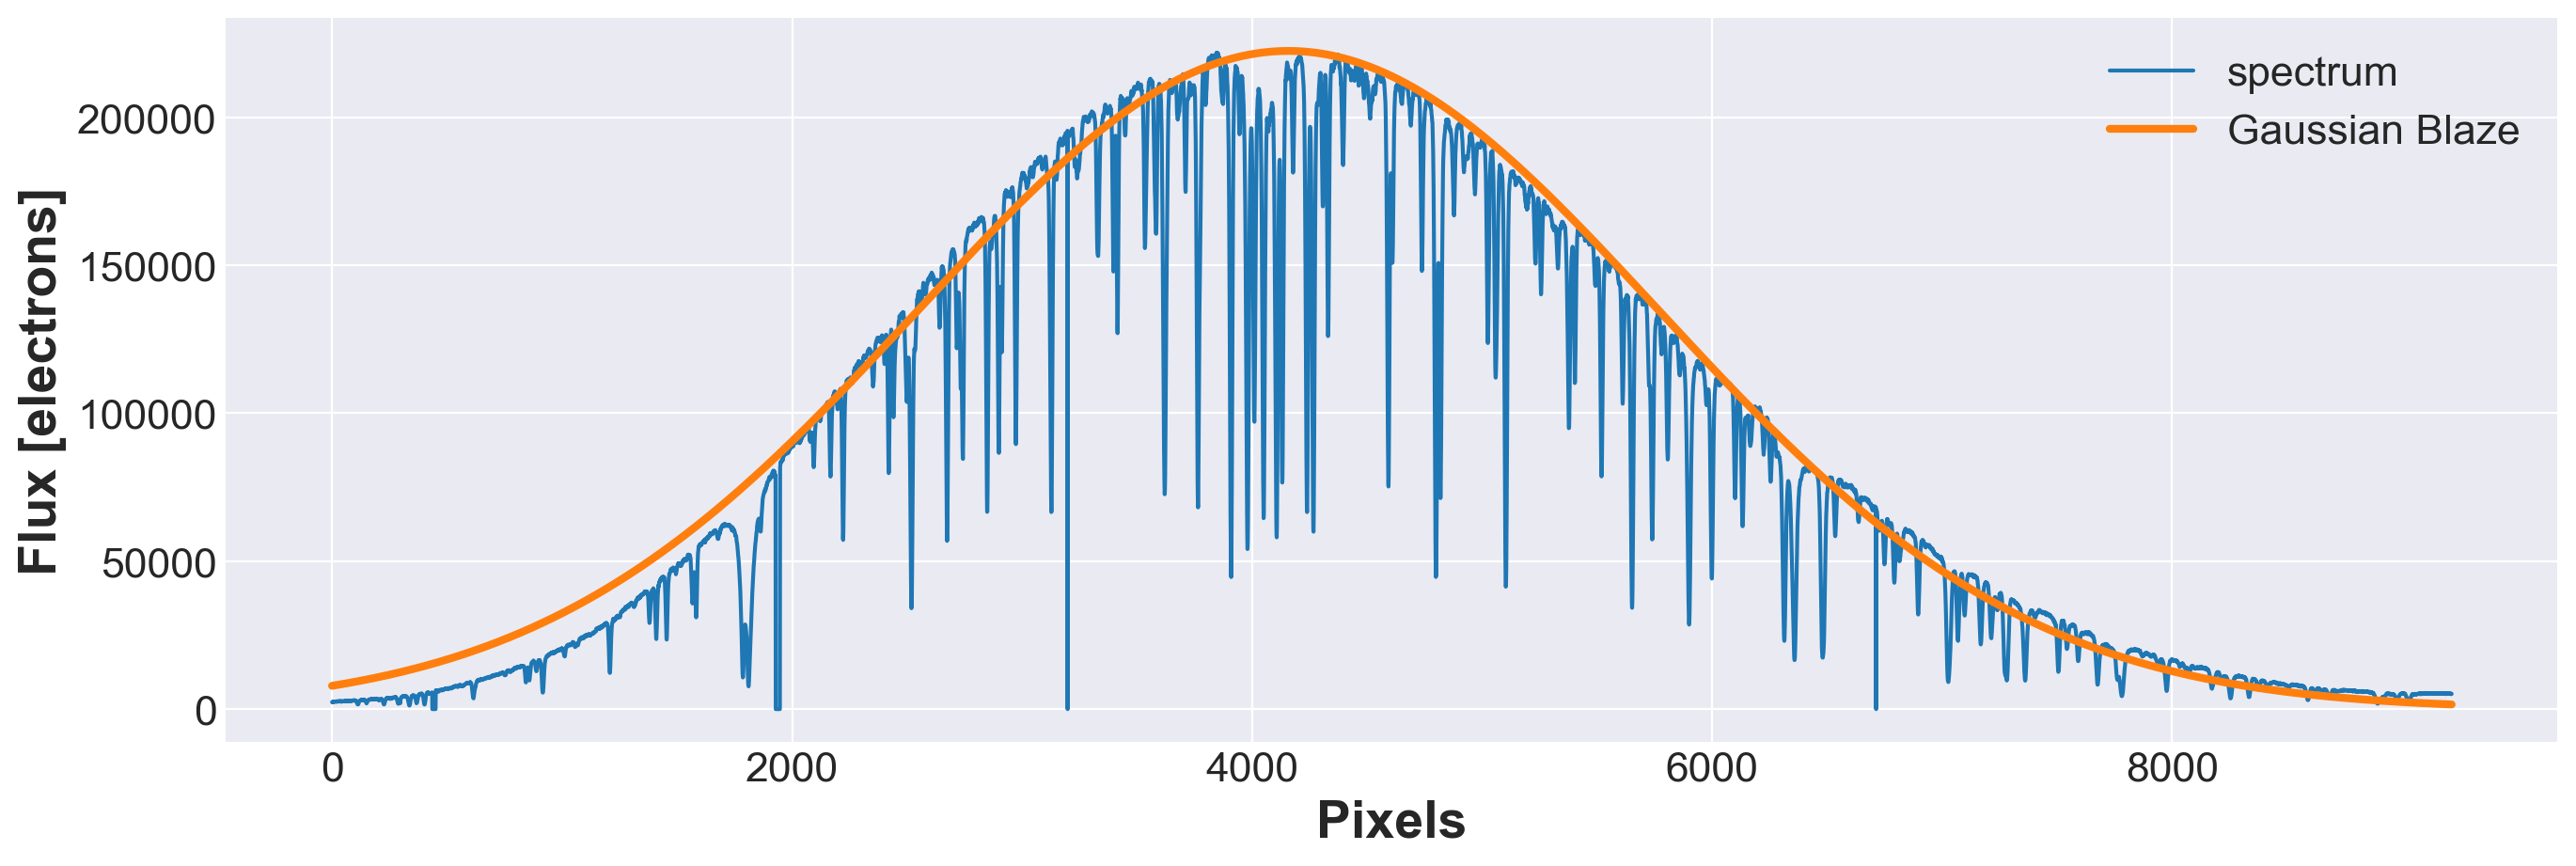

In [15]:
plt.plot(flux[order,:],label='spectrum')
plt.plot(blaze(pix_array),label='Gaussian Blaze',lw=3)
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Flux [electrons]')

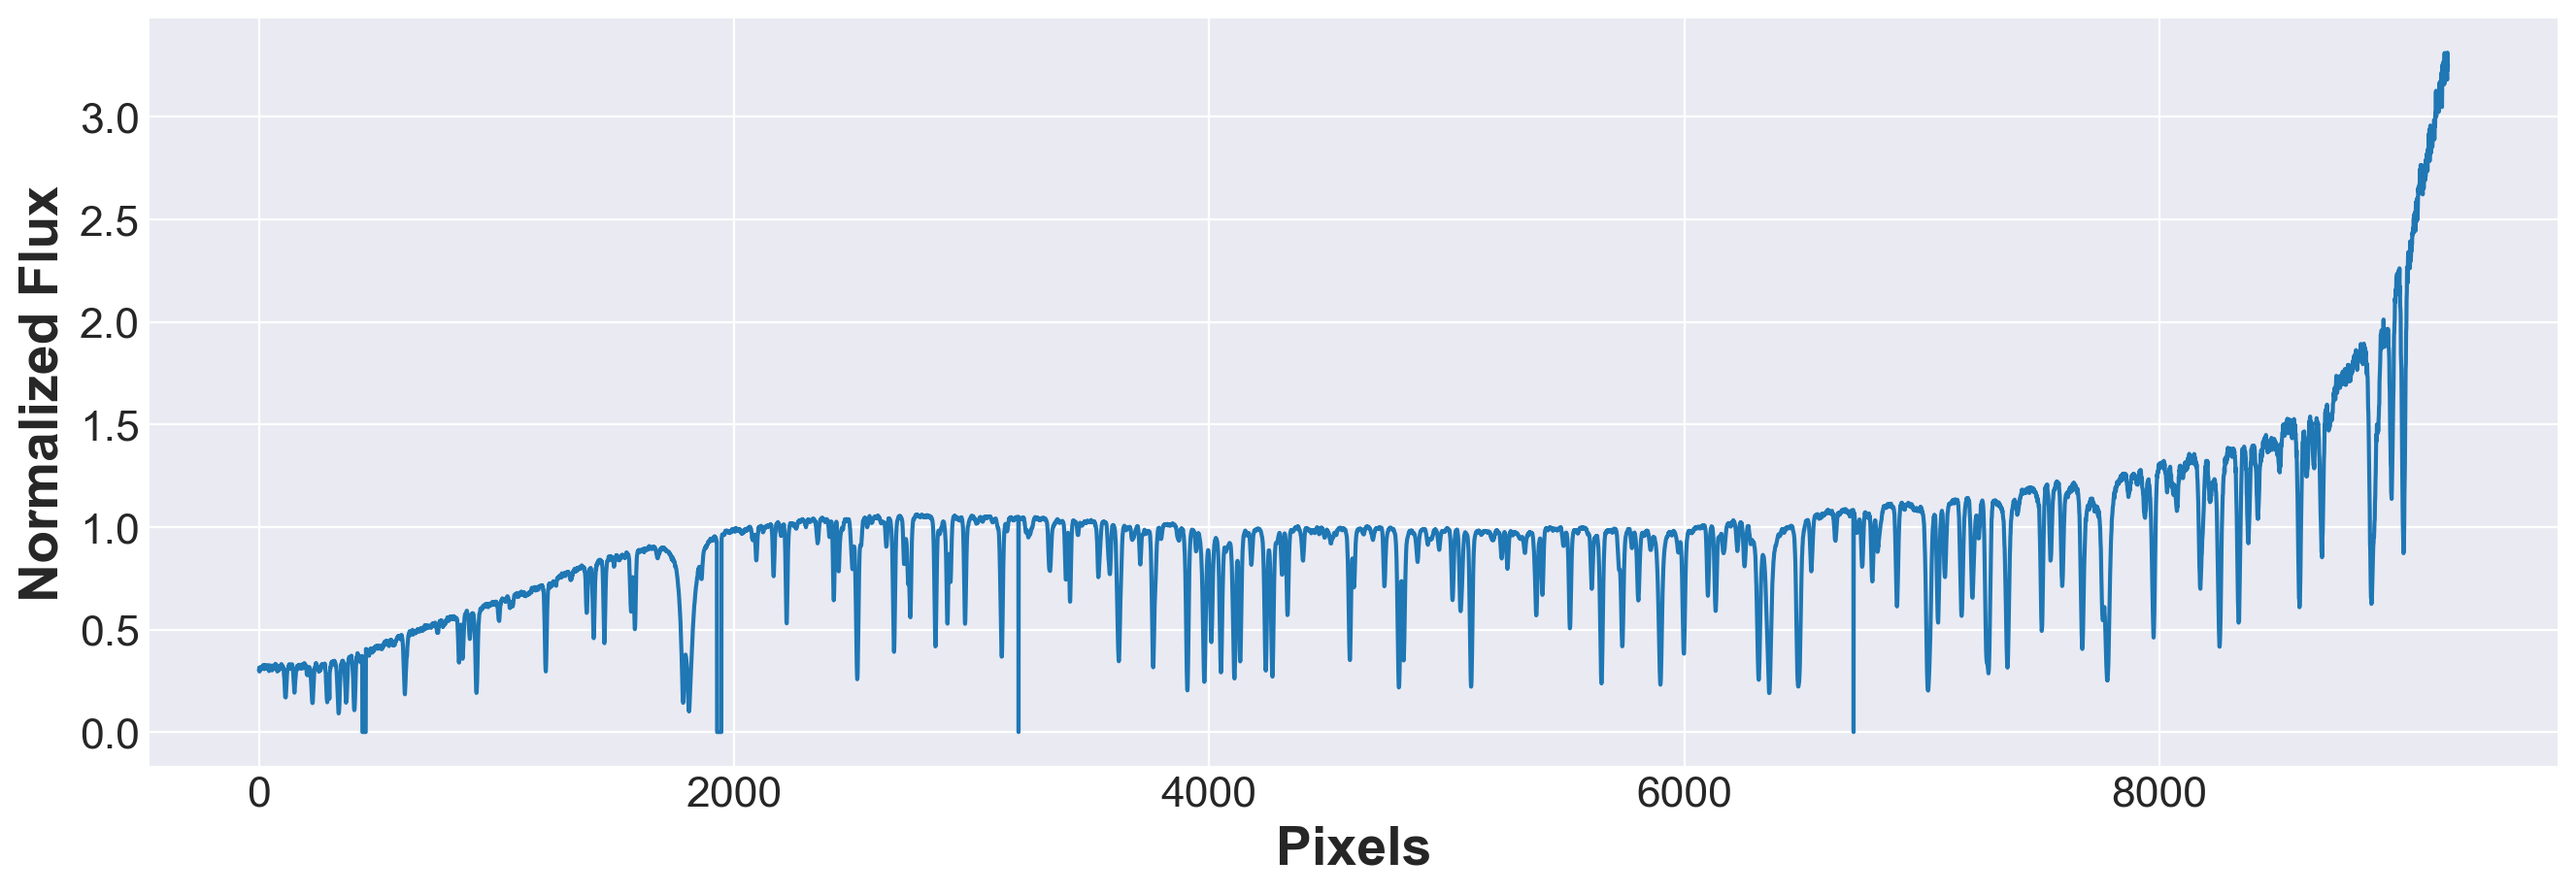

In [16]:
plt.plot(flux[order,:]/blaze(pix_array),label='spectrum')
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')
plt.show()

### C) Fit Skew Gaussian

In [17]:
model = SkewedGaussianModel()

# set initial parameter values
params = model.make_params(amplitude=2e5, center=4500, sigma=1000, gamma=1)

# adjust parameters  to best fit data.
result = model.fit(chunks_y, params, x=chunks_x)

skew_blaze = np.interp(pix_array, chunks_x, result.best_fit)

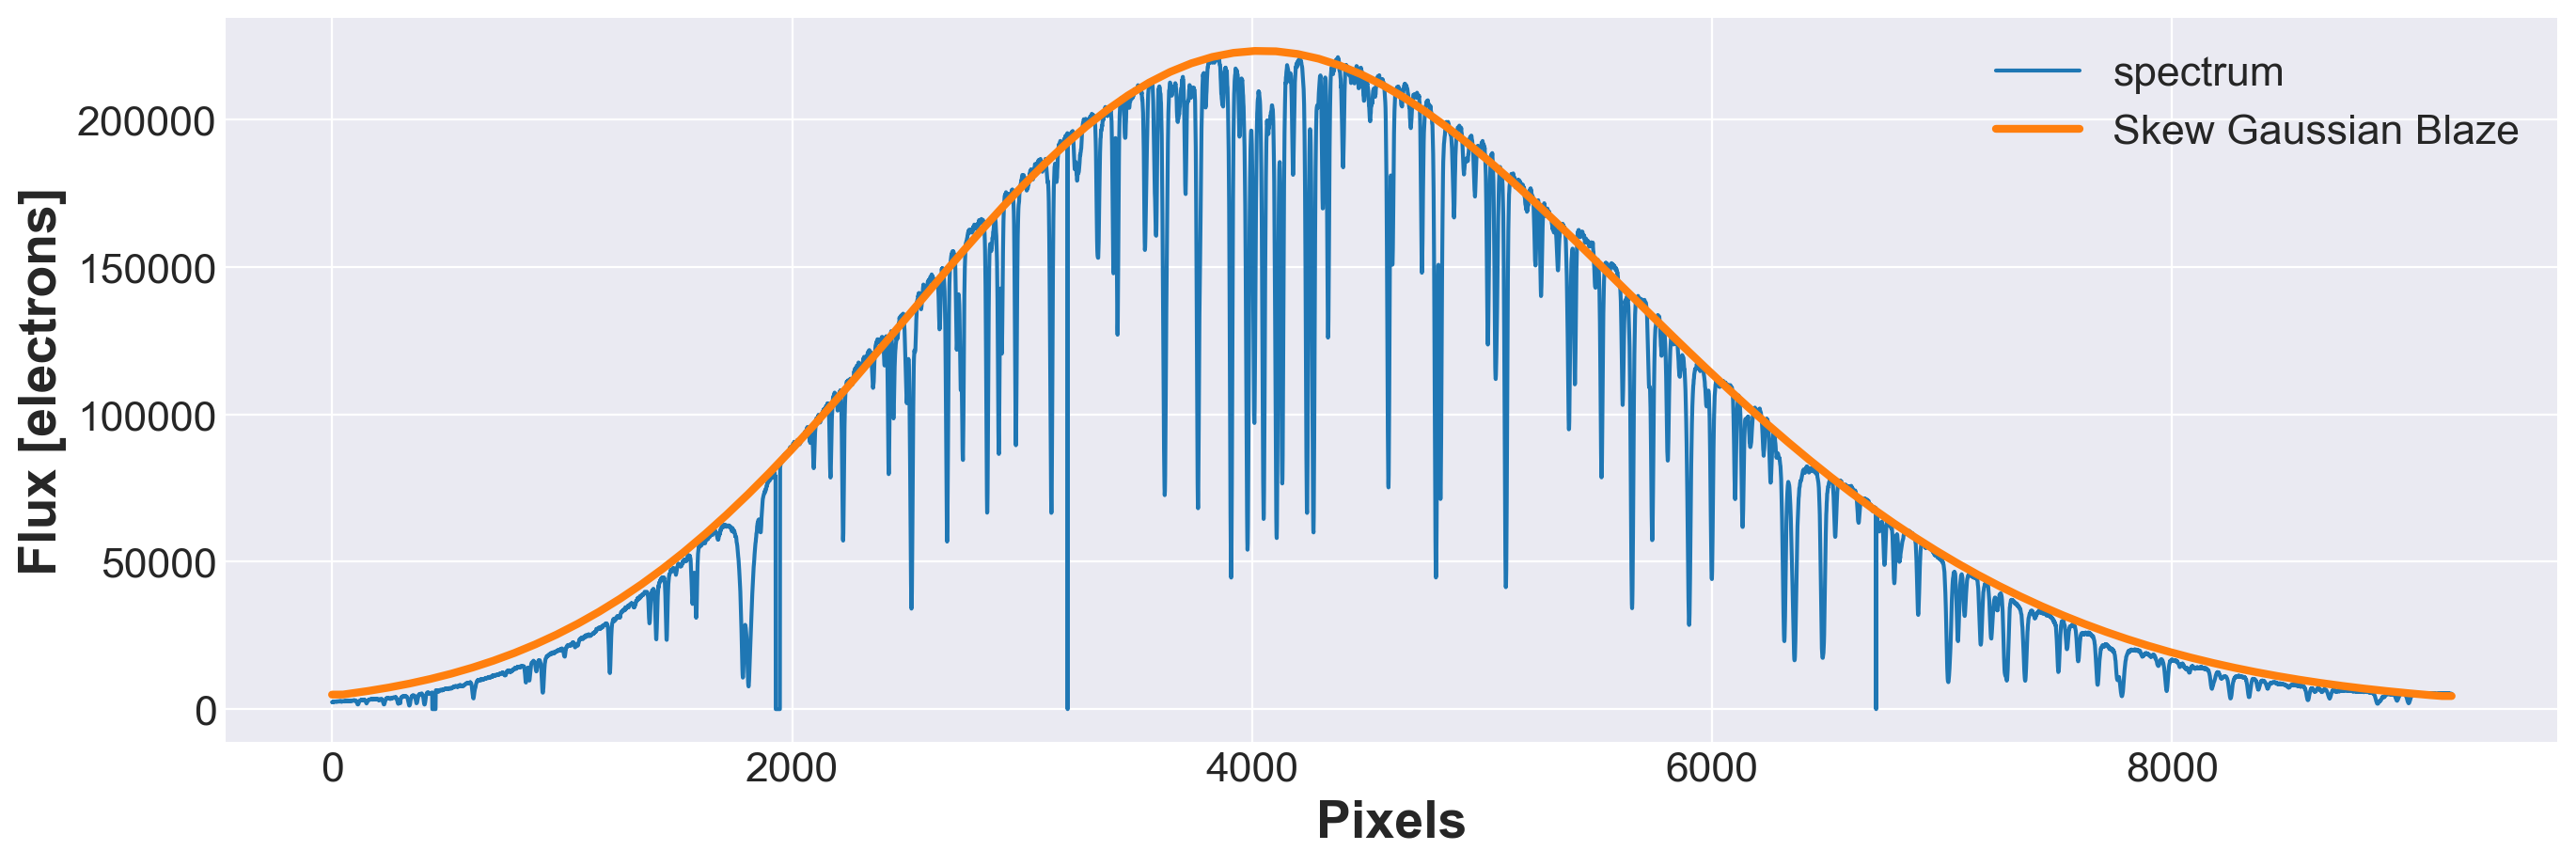

In [18]:
plt.plot(flux[order,:],label='spectrum')
plt.plot(skew_blaze,lw=3,label='Skew Gaussian Blaze')
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Flux [electrons]')
plt.show()

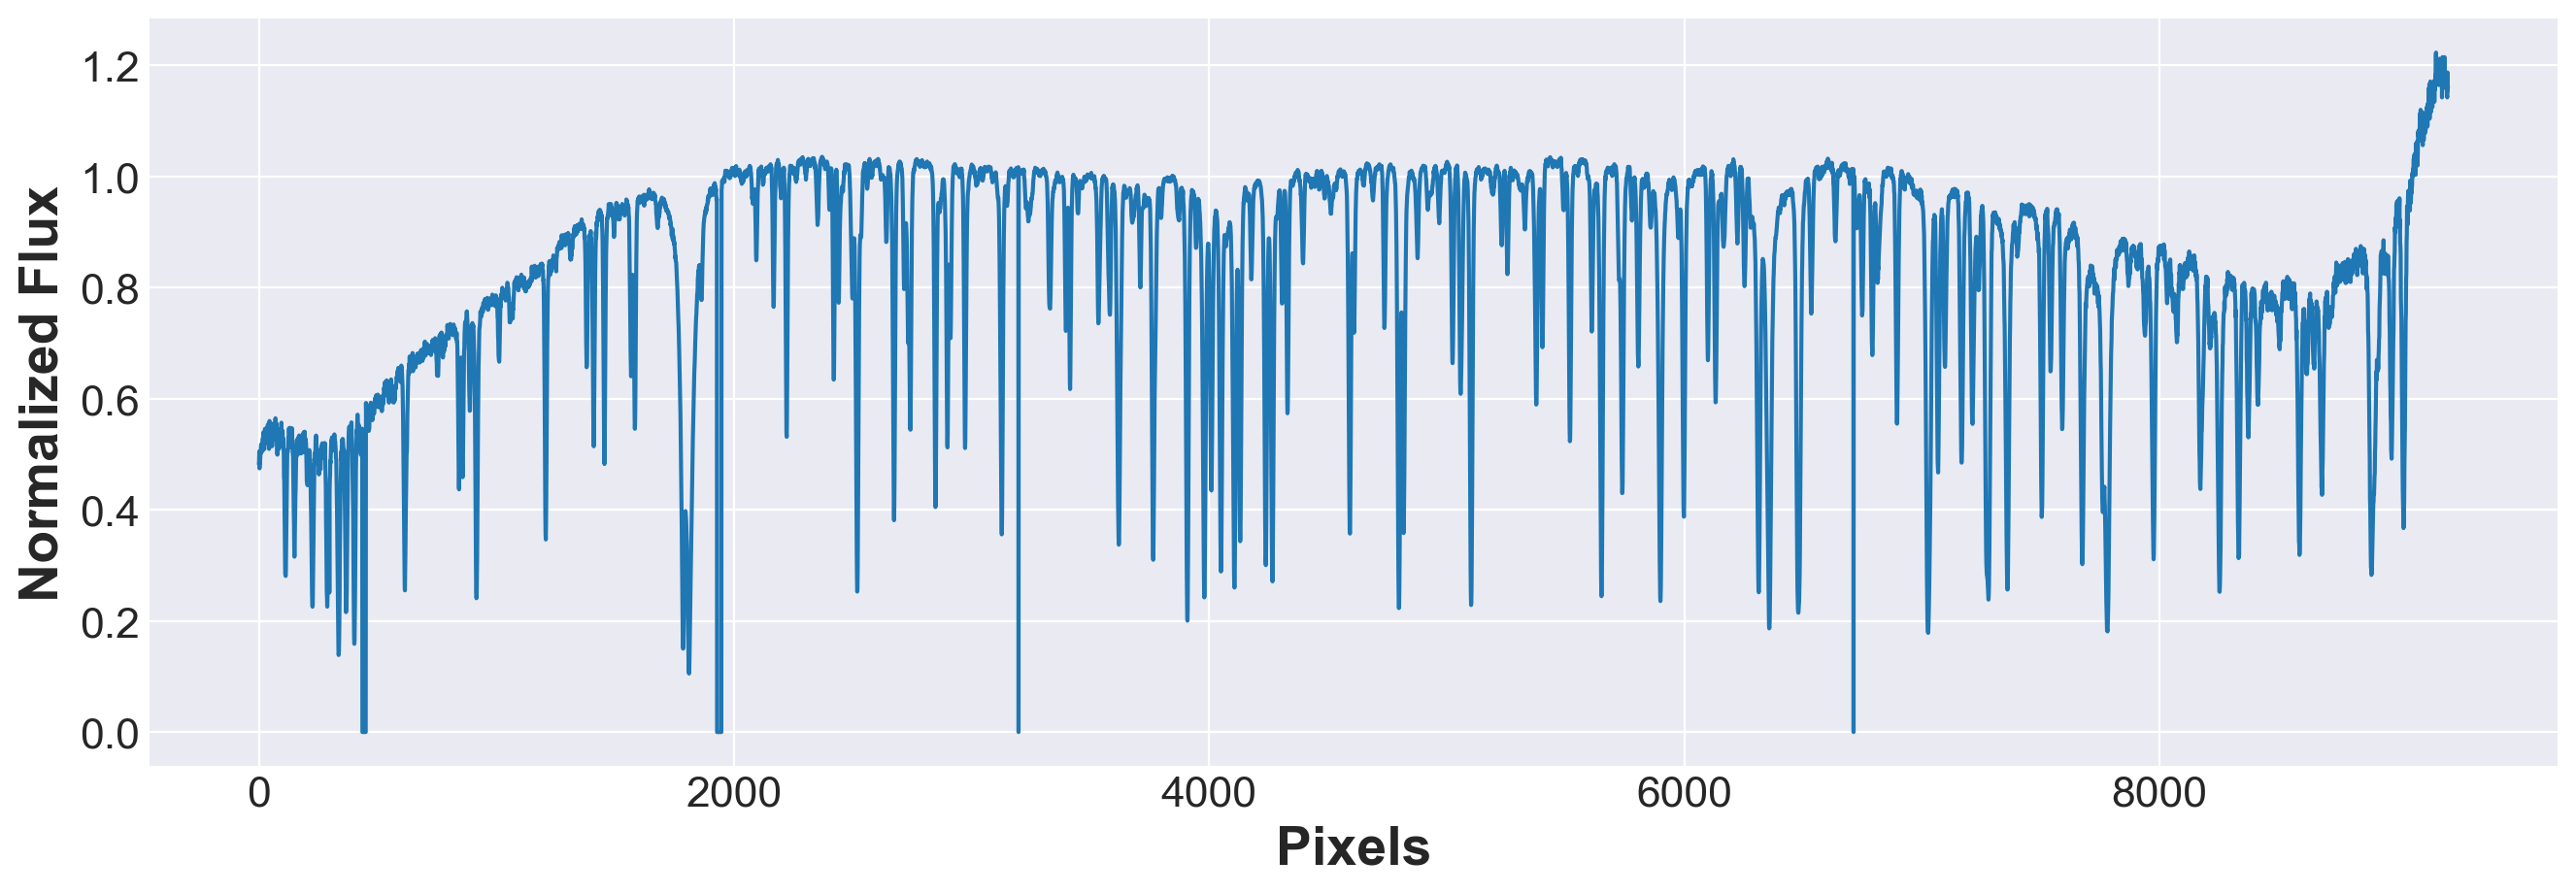

In [19]:
plt.plot(flux[order,:]/skew_blaze,label='spectrum')
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')
plt.show()

### Which one is best?

None of these continuum normalization routines are perfect, but consider which one works best for your science purposes.

Other routines to consider include [RASSINE](https://github.com/MichaelCretignier/Rassine_public), and [alpha shape fitting](https://ui.adsabs.harvard.edu/abs/2019AJ....157..243X/abstract). These can be slow, however, and not always better than simple polynomial or spline fitting.

## 4. Peak Finding <a class="anchor" id="findpeak"></a>

There are many ways to look for peaks. A simple one might be to just have an intensity threshold. We will use the cubic spline continuum normalization in this example.

In [20]:
spec_cont = flux[order,:]/cs(pix_array)

In [21]:
thresh = 0.8
idx = np.where(spec_cont < thresh)

Text(0, 0.5, 'Normalized Flux')

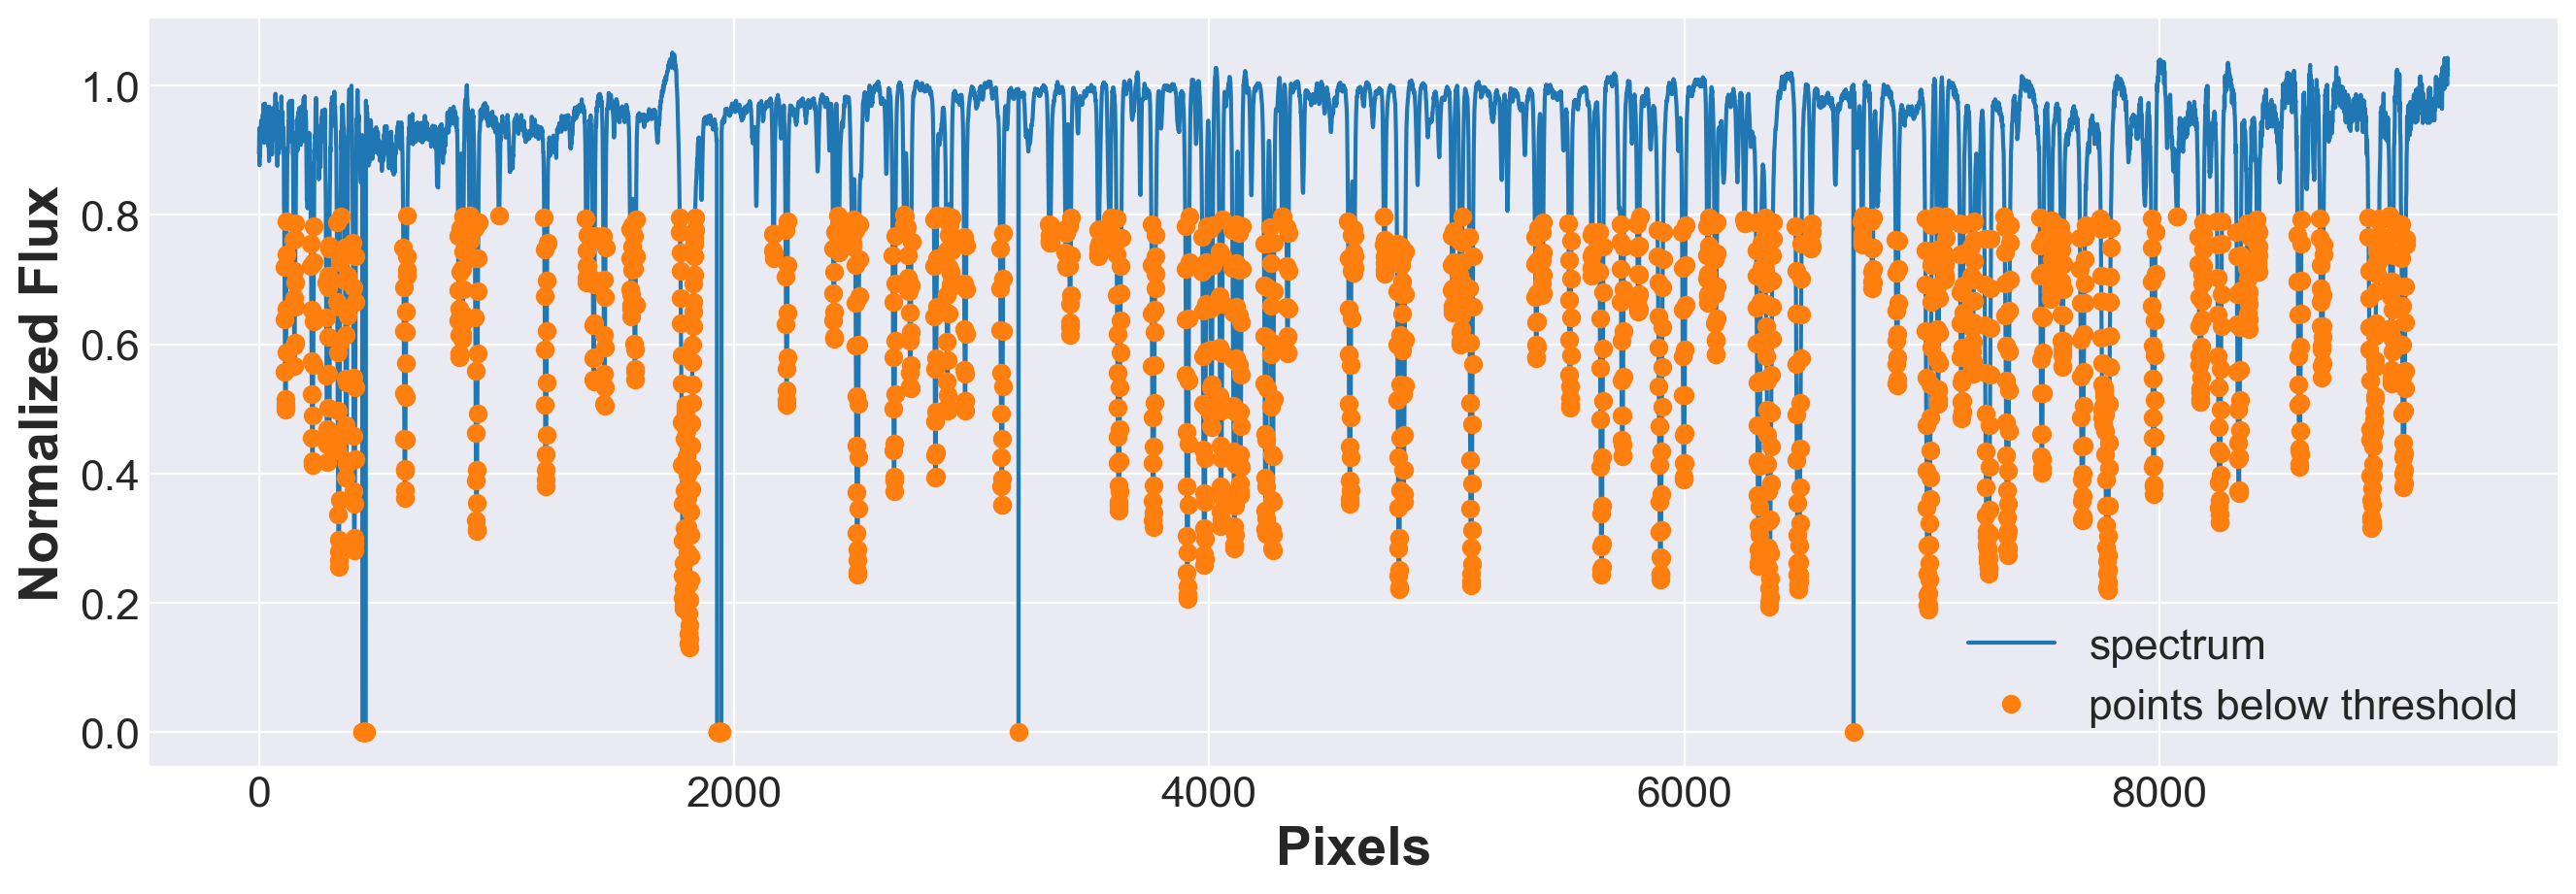

In [22]:
plt.plot(pix_array,spec_cont,label='spectrum')
plt.plot(pix_array[idx],spec_cont[idx],'o',label='points below threshold')
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')

(1350.0, 1500.0)

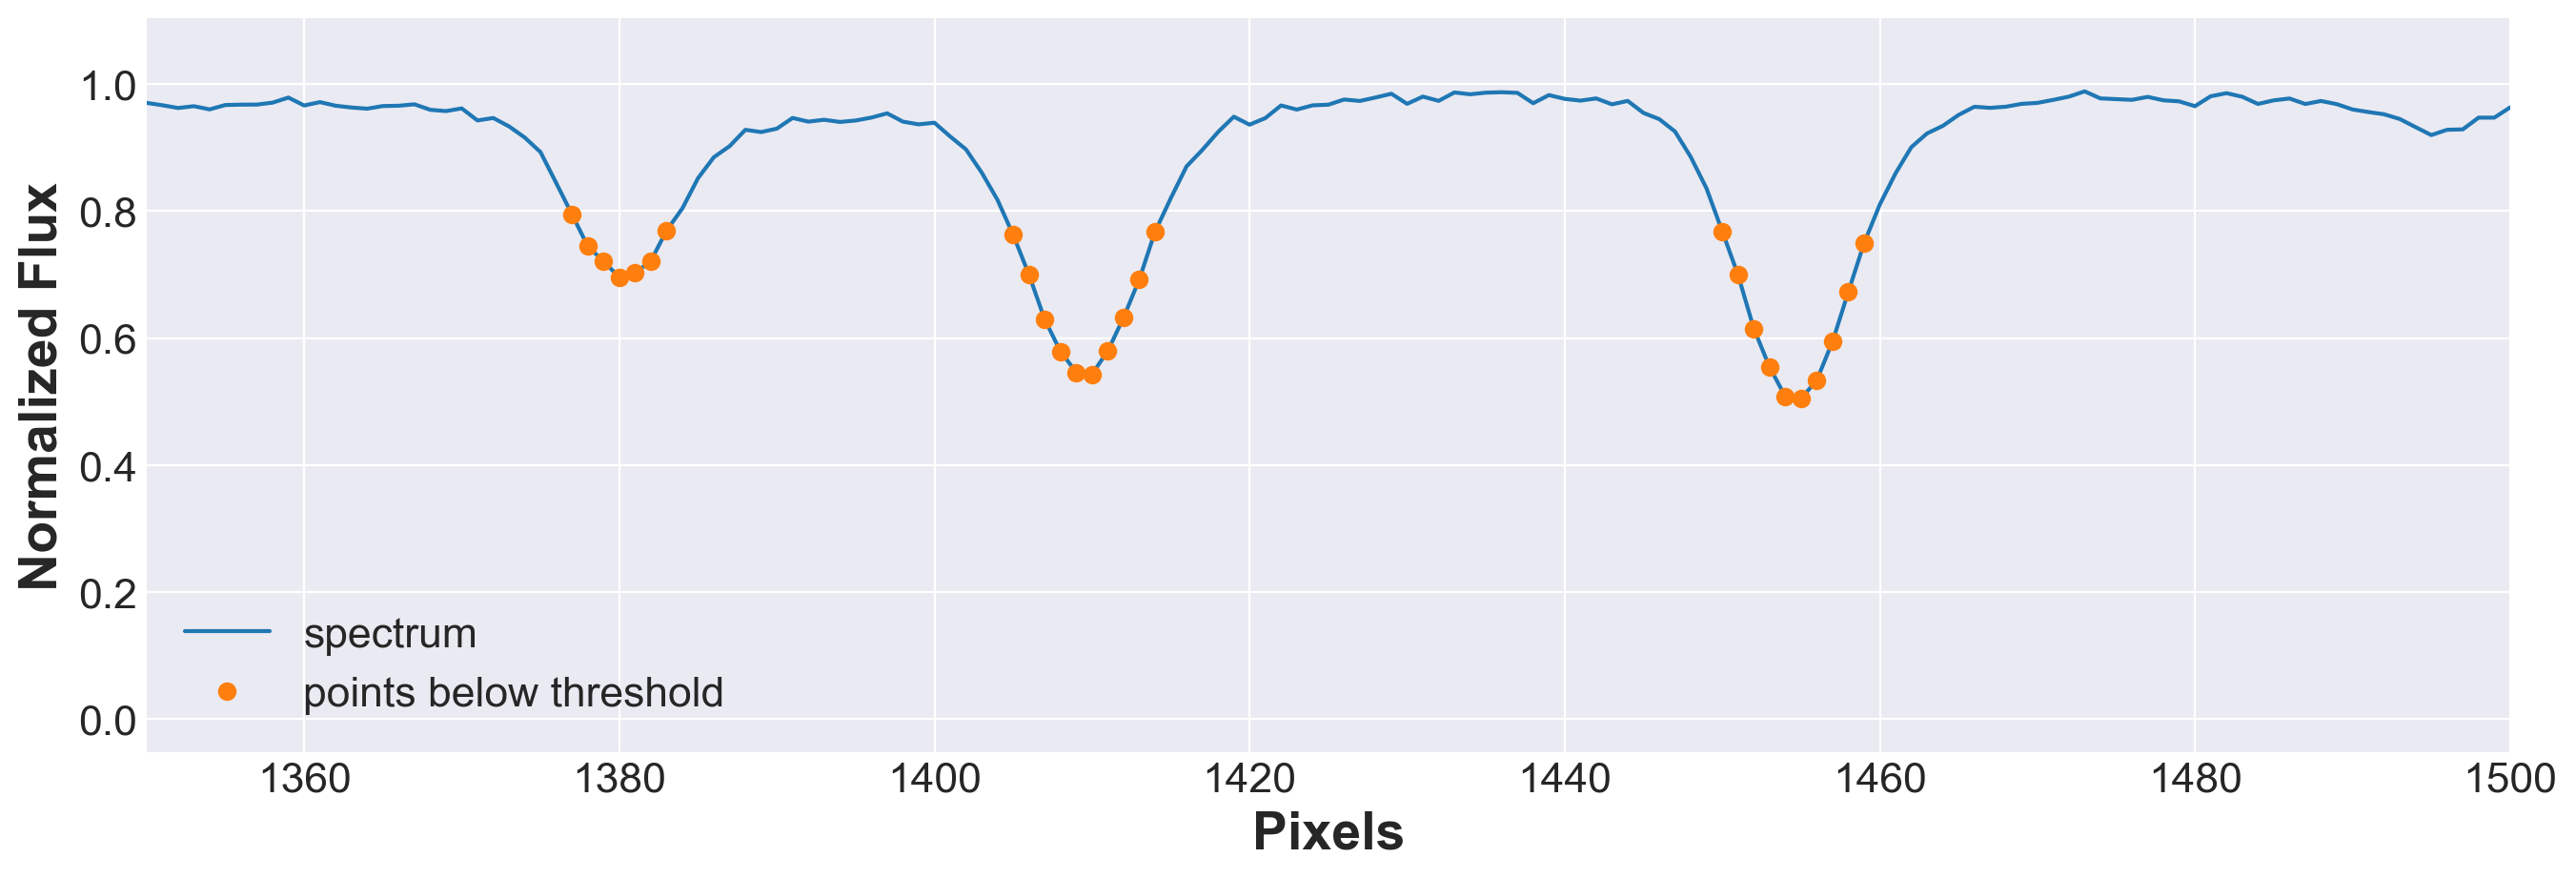

In [23]:
plt.plot(pix_array,spec_cont,label='spectrum')
plt.plot(pix_array[idx],spec_cont[idx],'o',label='points below threshold')
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')
plt.xlim(1350,1500)

However, at this point, you still have to do some more analysis to detect the actual peak positions, and to make sure you only detect each peak once.

A better way to find peaks is to use the derivative of the spectrum and look for zero crossings -- this is where the slope of the line changes direction and passes through zero, as it does at the peak of a line.

In [24]:
# Take first derivative
derivative = np.gradient(spec_cont)

# Smooth out some of the noise
smooth_derivative = savgol_filter(derivative, 11, 5)

# Find zero crossings
zero_crossings = np.where(np.diff(np.signbit(smooth_derivative)))[0]

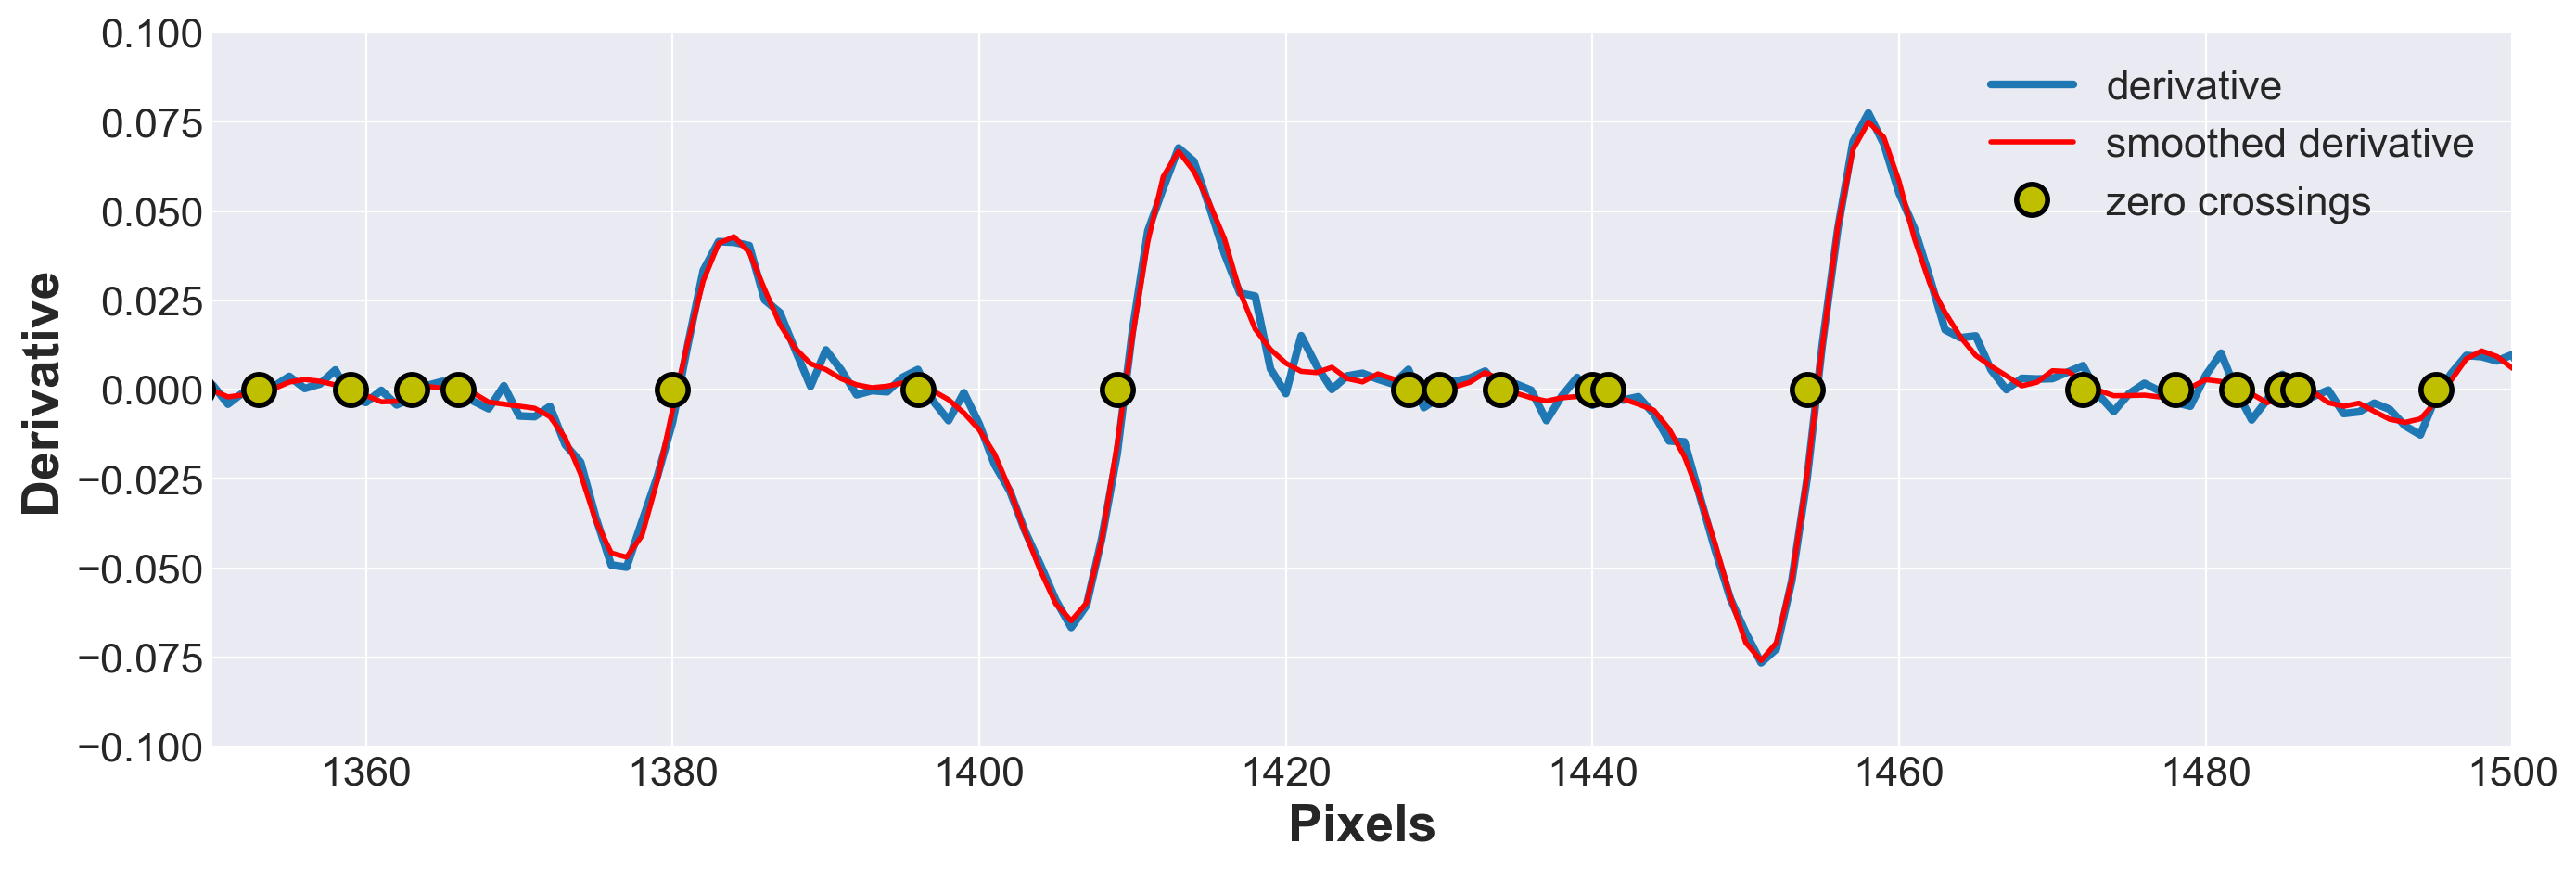

In [25]:
plt.plot(derivative,lw=3,label='derivative')
plt.plot(smooth_derivative,c='r',lw=2,label='smoothed derivative')
plt.plot(zero_crossings,np.zeros(len(zero_crossings)), 'yo',ms=12,markeredgecolor='k',
         markeredgewidth=2,label='zero crossings')
plt.xlim(1350,1500)
plt.ylim(-0.1,0.1)
plt.xlabel('Pixels')
plt.ylabel('Derivative')
plt.legend()

There are many "nuisance" zero crossings due to noise in spectrum, but you should be able to clearly see the centers of the lines we are trying to detect. To isolate these, let us put in some quality cuts. The  

In [26]:
good_lines = []

for zero_crossing in zero_crossings:
    # cut off pixels at very edge of detector
    if 20 < zero_crossing < 9000: 
        
        # Make sure first derivate is going from negative to positive
        slope = smooth_derivative[zero_crossing-1] - smooth_derivative[zero_crossing+1]
        
        # Im setting these numbers after experimenting with different slope cuts
        if -0.38 < slope < -0.01:
            good_lines.append(zero_crossing)
            #print(zero_crossing,slope)

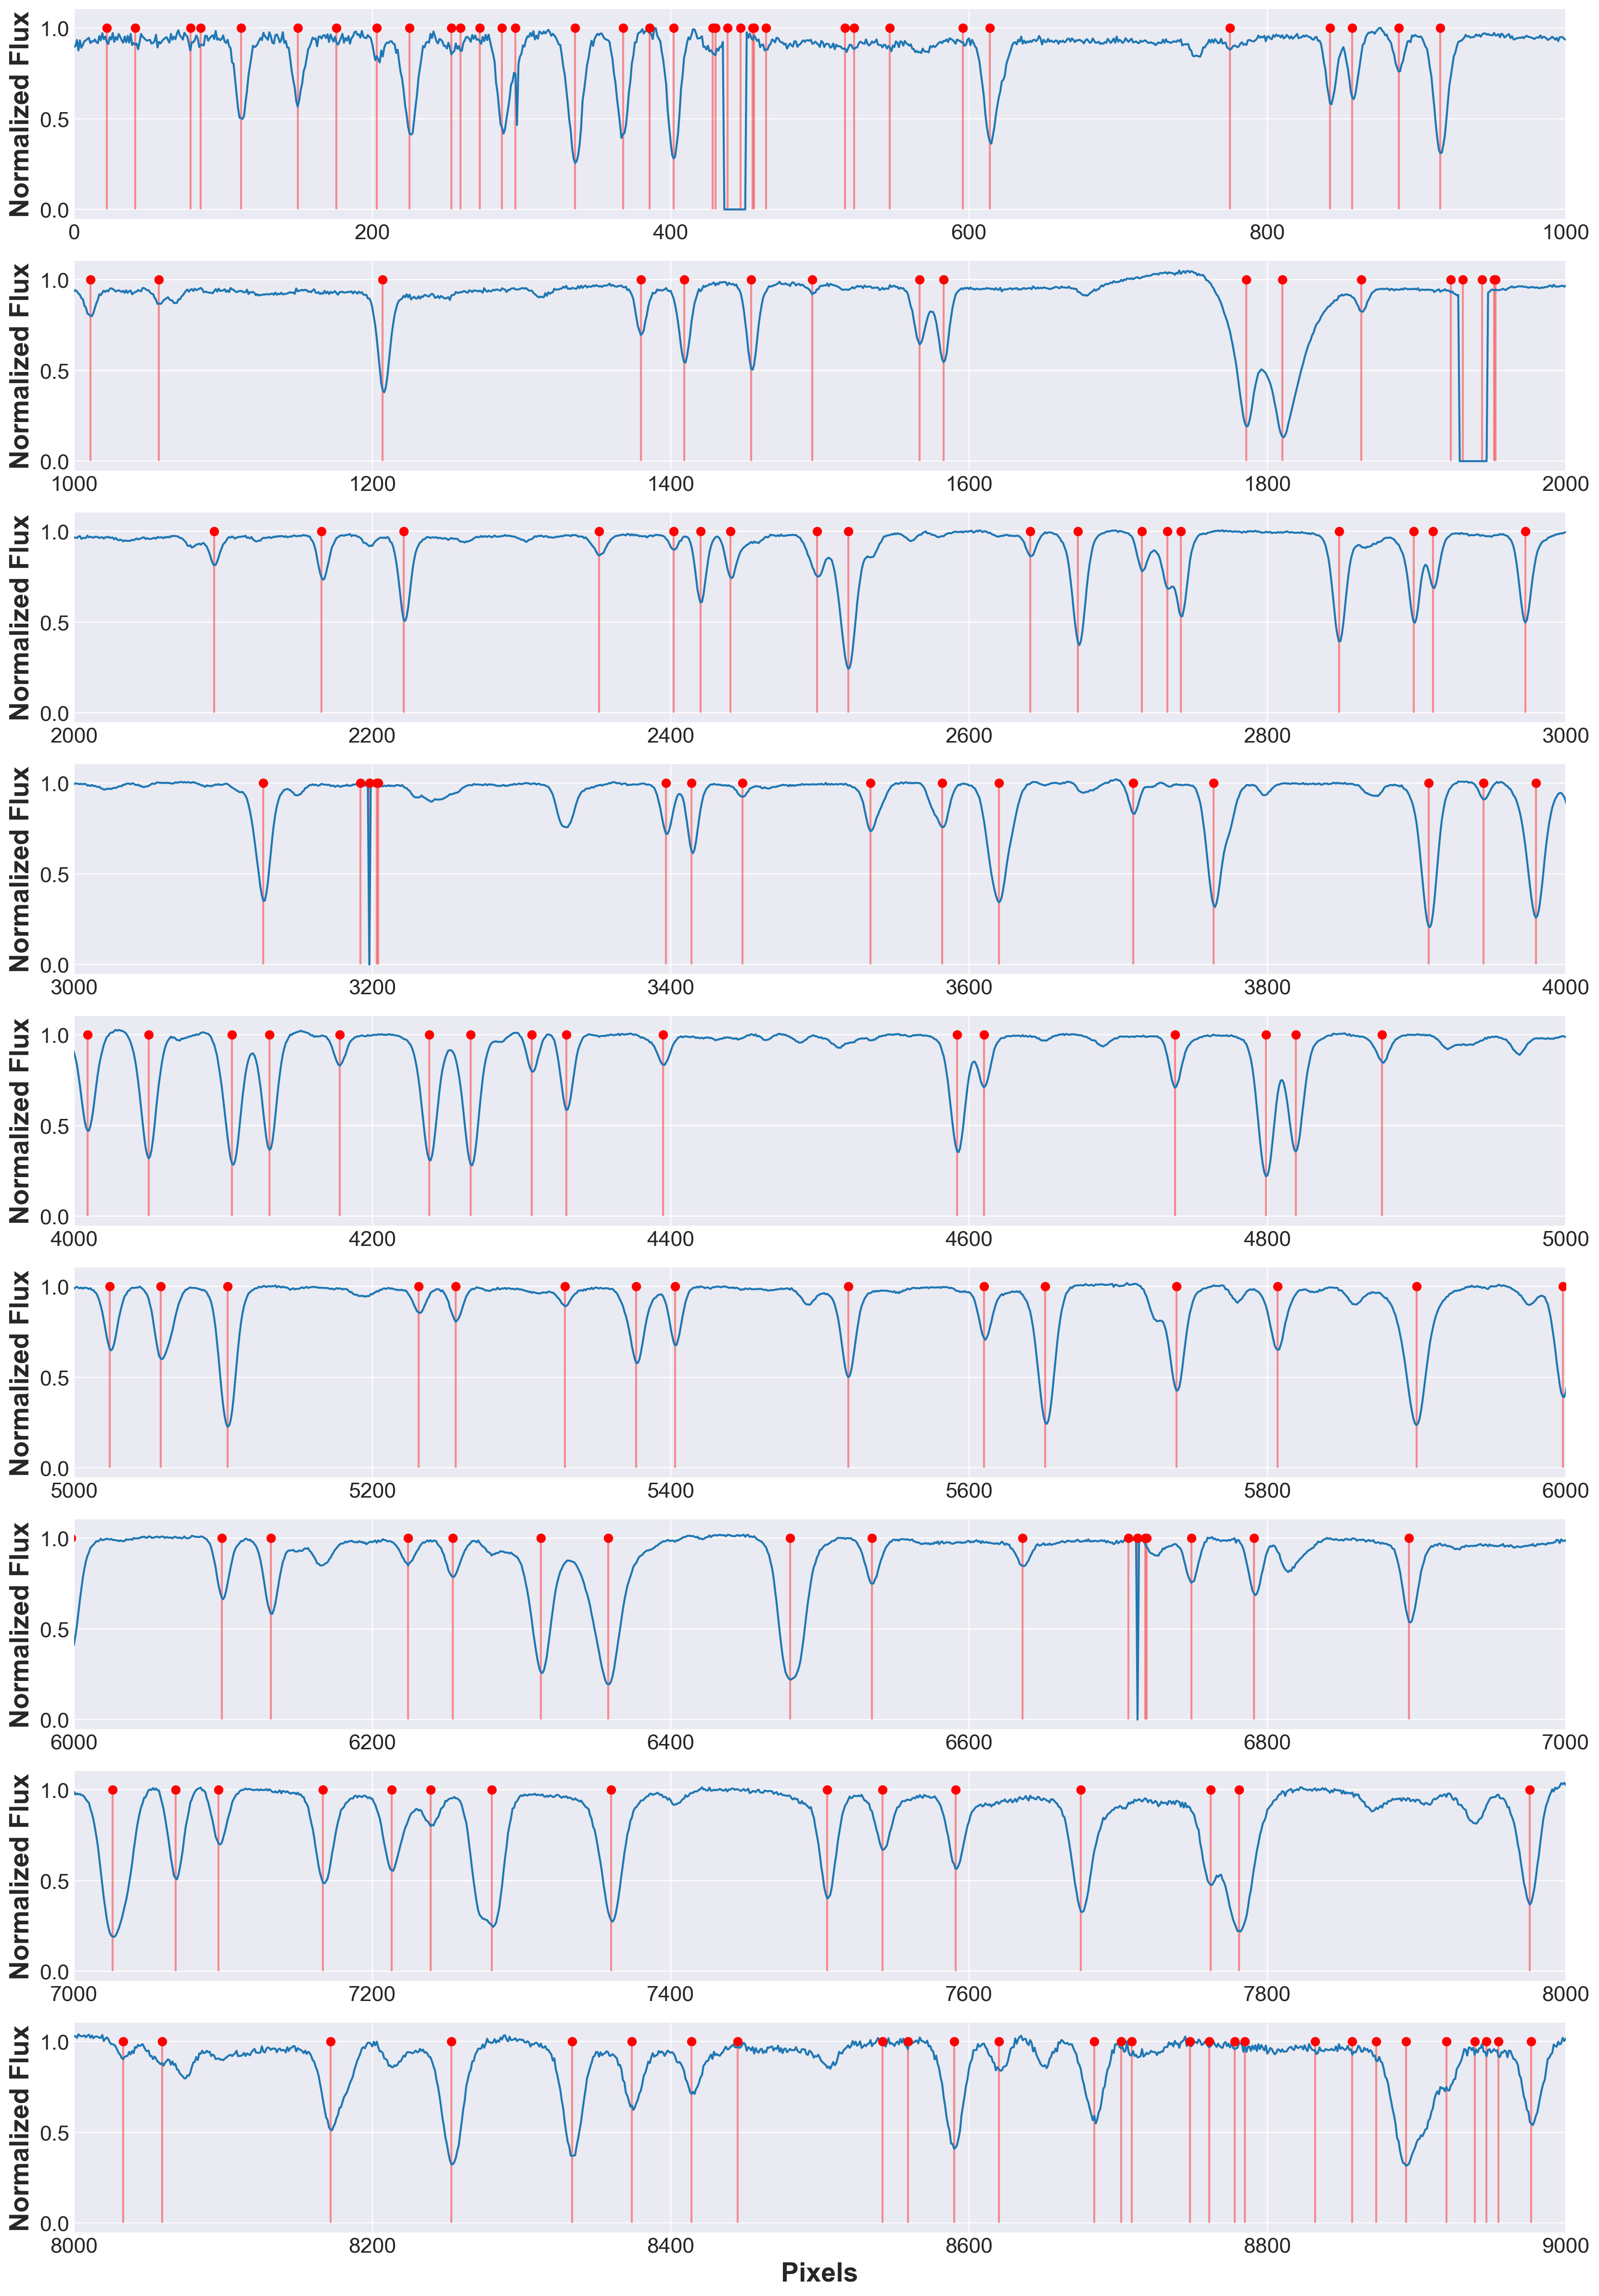

In [27]:
fig, axs = plt.subplots(nrows=9,figsize=(20,30))

for i in range(9):
    axs[i].plot(spec_cont)
    axs[i].plot(good_lines,np.repeat(1,len(good_lines)),'ro')
    axs[i].vlines(good_lines,0,1,color='r',alpha=0.4)
    axs[i].set_xlim(i*1000,(i+1)*1000)
    axs[i].set_ylabel('Normalized Flux')
axs[i].set_xlabel('Pixels')
plt.show()

Not bad. There are a few noisy regions at the edges of the spectrum where we picked up excessive points, and some bad pixel or cosmic rays regions (that look like top hat shapes) that aren't real spectral lines, but other than that this is a good place to start making a line list for this order.

## 5. Peak Fitting <a class="anchor" id="fitpeak"></a>

Spectral lines are well represented by Gaussians. Let's try measuring the properties of each line using the Gaussian approximation. As an example, we will fit a single line.

In [28]:
# We will pick a clean line to look at, 
# and examine some number of pixels around the supposed peak
pixrange = 15
linenum = 104
schunk = spec_cont[(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
# Let's flip the chunk so that the fitting routine has an easier time
upside = -schunk + 1
xchunk = np.arange(len(schunk))

# Gaussian model to use - you need to give it reasonable starting parameters
g_init = models.Gaussian1D(amplitude=2., mean=pixrange, stddev=6)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xchunk, upside)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    0.7790247335975687 15.208281929417334 5.367061169010217


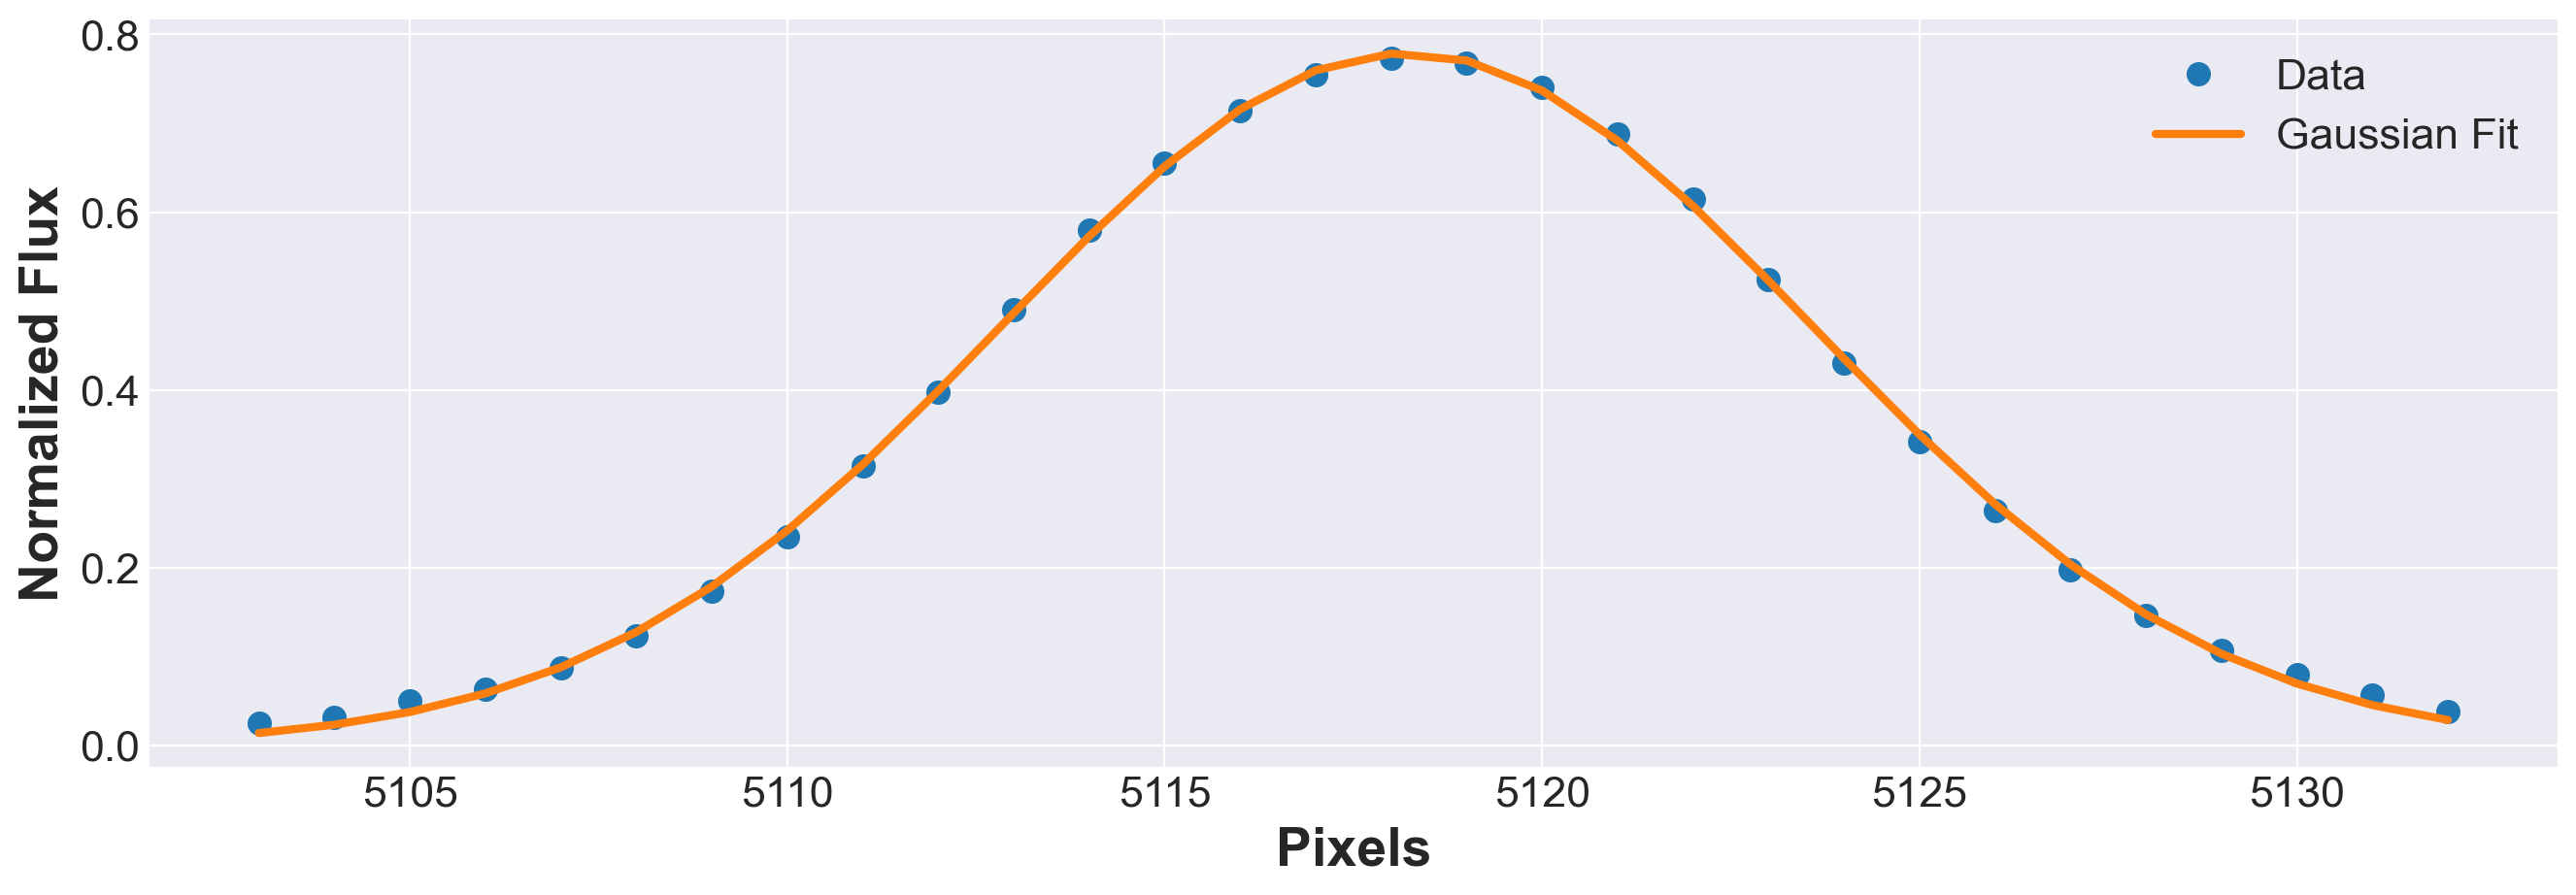

In [29]:
plt.plot(good_lines[linenum]+xchunk, upside, 'o',ms=8,label='Data')
plt.plot(good_lines[linenum]+xchunk, g(xchunk),lw=3,label='Gaussian Fit')
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')
plt.legend()
print(g)

Great! However, we'd actually like these line centroids in wavelengths so let's translate the line center precisely to wavelength space.

In [30]:
wchunk = wave[order,(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
line_centroid_pixel = good_lines[linenum] -pixrange + g.mean.value
line_centroid_wavelength = np.interp(line_centroid_pixel, pix_array, wave[order,:])

Here is our line on the full spectrum.

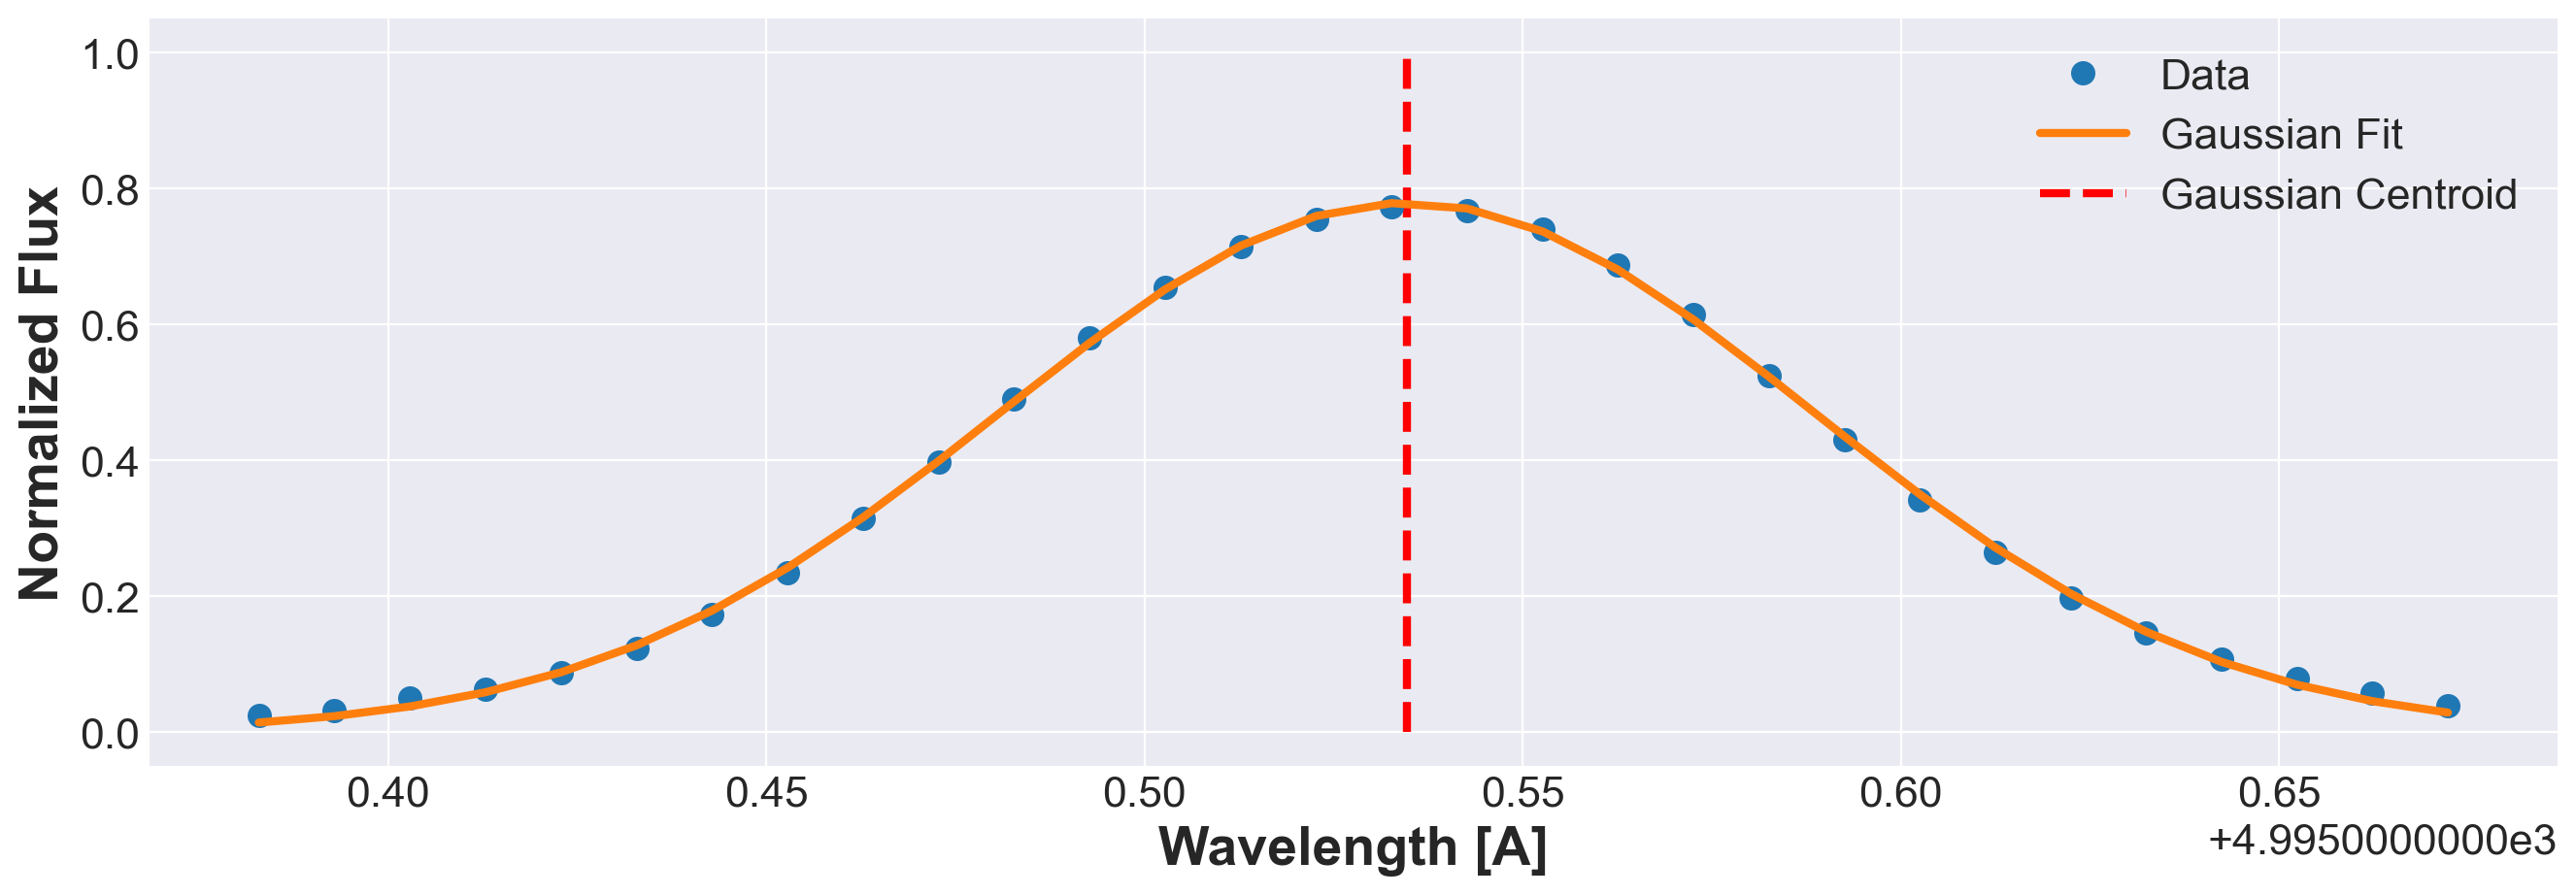

In [31]:
fig,ax=plt.subplots()
ax.plot(wchunk, upside,'o',ms=8,label='Data')
plt.plot(wchunk,g(xchunk),lw=3,label='Gaussian Fit')
ax.vlines(line_centroid_wavelength,0,1,color='r',linestyle='--',lw=3,label='Gaussian Centroid')
plt.xlabel('Wavelength [A]')
plt.ylabel('Normalized Flux')
plt.legend()

You can now do this for all the zero crossings that we found to generate a line list in wavelengths. 

Note that many of the "lines" we found are not really deep, well-separated absorption features, so you could also do some quality checks on the fitted Gaussian parameters and throw out those that are not well-represented by a Gaussian. Some typical checks I like to do:
- make sure centroid is inside the fitting window
- make sure stddev is in some range (can decide this from looking at obviosuly clean lines)
- make sure amplitude is positive (or negative, if you are not flipping the lines)

Also, spectral lines are better represented by skewed Gaussians or Voigt profiles (Gaussian + Lorentzian). Those are other fitting functions you might try.